# Implementation of a Diffusion model on the MNIST dataset 

## Import statements

In [1]:
import os
import math
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torchvision.datasets import MNIST
from torchvision import transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from tqdm import tqdm

In [2]:
class ExponentialMovingAverage(torch.optim.swa_utils.AveragedModel):
    """Maintains moving averages of model parameters using an exponential decay."""
    def __init__(self, model, decay, device="cpu"):
        def ema_avg(avg_model_param, model_param):
            return decay * avg_model_param + (1 - decay) * model_param

        super().__init__(model, device, ema_avg, use_buffers=True)

In [3]:
def create_mnist_dataloaders(batch_size, image_size=28, num_workers=4):
    preprocess = transforms.Compose([transforms.Resize(image_size), transforms.ToTensor(),
                                     transforms.Normalize([0.5], [0.5])])  # [0,1] to [-1,1]
    train_dataset = MNIST(root="../data", train=True, download=True, transform=preprocess)
    test_dataset = MNIST(root="../data", train=False, download=True, transform=preprocess)
    return DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers), \
        DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

## U-Net

In [4]:
class ChannelShuffle(nn.Module):
    def __init__(self, groups):
        super().__init__()
        self.groups = groups

    def forward(self, x):
        n, c, h, w = x.shape
        x = x.view(n, self.groups, c // self.groups, h, w)  # group
        x = x.transpose(1, 2).contiguous().view(n, -1, h, w)  # shuffle
        return x

In [5]:
class ConvBnSiLu(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super().__init__()
        self.module = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding),
                                    nn.BatchNorm2d(out_channels),
                                    nn.SiLU(inplace=True))

    def forward(self, x):
        return self.module(x)

In [6]:
class ResidualBottleneck(nn.Module):
    """ShuffleNet_v2 basic unit(https://arxiv.org/pdf/1807.11164.pdf)"""
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.branch1 = nn.Sequential(nn.Conv2d(in_channels // 2, in_channels // 2, 3, 1, 1,
                                               groups=in_channels // 2), nn.BatchNorm2d(in_channels // 2),
                                     ConvBnSiLu(in_channels // 2, out_channels // 2, 1, 1, 0))
        self.branch2 = nn.Sequential(ConvBnSiLu(in_channels // 2, in_channels // 2, 1, 1, 0),
                                     nn.Conv2d(in_channels // 2, in_channels // 2, 3, 1, 1,
                                               groups=in_channels // 2), nn.BatchNorm2d(in_channels // 2),
                                     ConvBnSiLu(in_channels // 2, out_channels // 2, 1, 1, 0))
        self.channel_shuffle = ChannelShuffle(2)

    def forward(self, x):
        x1, x2 = x.chunk(2, dim=1)
        x = torch.cat([self.branch1(x1), self.branch2(x2)], dim=1)
        x = self.channel_shuffle(x)  # shuffle two branches
        return x

In [7]:
class ResidualDownsample(nn.Module):
    """ShuffleNet_v2 unit for spatial down sampling(https://arxiv.org/pdf/1807.11164.pdf)"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.branch1 = nn.Sequential(nn.Conv2d(in_channels, in_channels, 3, 2, 1,
                                               groups=in_channels), nn.BatchNorm2d(in_channels),
                                     ConvBnSiLu(in_channels, out_channels // 2, 1, 1, 0))
        self.branch2 = nn.Sequential(ConvBnSiLu(in_channels, out_channels // 2, 1, 1, 0),
                                     nn.Conv2d(out_channels // 2, out_channels // 2, 3, 2, 1,
                                               groups=out_channels // 2), nn.BatchNorm2d(out_channels // 2),
                                     ConvBnSiLu(out_channels // 2, out_channels // 2, 1, 1, 0))
        self.channel_shuffle = ChannelShuffle(2)

    def forward(self, x):
        x = torch.cat([self.branch1(x), self.branch2(x)], dim=1)
        x = self.channel_shuffle(x)  # shuffle two branches
        return x

In [8]:
class TimeMLP(nn.Module):
    """Introduction of timestep information to feature maps with mlp."""
    def __init__(self, embedding_dim, hidden_dim, out_dim):
        super().__init__()
        self.mlp = nn.Sequential(nn.Linear(embedding_dim, hidden_dim),
                                 nn.SiLU(),
                                 nn.Linear(hidden_dim, out_dim))
        self.act = nn.SiLU()

    def forward(self, x, t):
        t_emb = self.mlp(t).unsqueeze(-1).unsqueeze(-1)
        x = x + t_emb
        return self.act(x)

In [9]:
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_embedding_dim):
        super().__init__()
        self.conv0 = nn.Sequential(*[ResidualBottleneck(in_channels, in_channels) for i in range(3)],
                                   ResidualBottleneck(in_channels, out_channels // 2))
        self.time_mlp = TimeMLP(embedding_dim=time_embedding_dim, hidden_dim=out_channels, out_dim=out_channels // 2)
        self.conv1 = ResidualDownsample(out_channels // 2, out_channels)

    def forward(self, x, t=None):
        x_shortcut = self.conv0(x)
        if t is not None:
            x = self.time_mlp(x_shortcut, t)
        x = self.conv1(x)
        return [x, x_shortcut]

In [10]:
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_embedding_dim):
        super().__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.conv0 = nn.Sequential(*[ResidualBottleneck(in_channels, in_channels) for i in range(3)],
                                   ResidualBottleneck(in_channels, in_channels // 2))
        self.time_mlp = TimeMLP(embedding_dim=time_embedding_dim, hidden_dim=in_channels, out_dim=in_channels // 2)
        self.conv1 = ResidualBottleneck(in_channels // 2, out_channels // 2)

    def forward(self, x, x_shortcut, t=None):
        x = self.upsample(x)
        x = torch.cat([x, x_shortcut], dim=1)
        x = self.conv0(x)
        if t is not None:
            x = self.time_mlp(x, t)
        x = self.conv1(x)
        return x

In [11]:
class Unet(nn.Module):
    def __init__(self, timesteps, time_embedding_dim, in_channels=3, out_channels=2, base_dim=32,
                 dim_mults=[2, 4, 8, 16]):
        super().__init__()
        assert isinstance(dim_mults, (list, tuple))
        assert base_dim % 2 == 0

        channels = self._cal_channels(base_dim, dim_mults)

        self.init_conv = ConvBnSiLu(in_channels, base_dim, 3, 1, 1)
        self.time_embedding = nn.Embedding(timesteps, time_embedding_dim)

        self.encoder_blocks = nn.ModuleList([EncoderBlock(c[0], c[1], time_embedding_dim) for c in channels])
        self.decoder_blocks = nn.ModuleList([DecoderBlock(c[1], c[0], time_embedding_dim) for c in channels[::-1]])

        self.mid_block = nn.Sequential(*[ResidualBottleneck(channels[-1][1], channels[-1][1]) for i in range(2)],
                                       ResidualBottleneck(channels[-1][1], channels[-1][1] // 2))

        self.final_conv = nn.Conv2d(in_channels=channels[0][0] // 2, out_channels=out_channels, kernel_size=1)

    def forward(self, x, t=None):
        x = self.init_conv(x)
        if t is not None:
            t = self.time_embedding(t)
        encoder_shortcuts = []
        for encoder_block in self.encoder_blocks:
            x, x_shortcut = encoder_block(x, t)
            encoder_shortcuts.append(x_shortcut)
        x = self.mid_block(x)
        encoder_shortcuts.reverse()
        for decoder_block, shortcut in zip(self.decoder_blocks, encoder_shortcuts):
            x = decoder_block(x, shortcut, t)
        x = self.final_conv(x)
        return x

    def _cal_channels(self, base_dim, dim_mults):
        dims = [base_dim * x for x in dim_mults]
        dims.insert(0, base_dim)
        channels = []
        for i in range(len(dims) - 1):
            channels.append((dims[i], dims[i + 1]))  # in_channel, out_channel
        return channels

## Diffusion Model

In [13]:
class MNISTDiffusion(nn.Module):
    def __init__(self, image_size, in_channels, time_embedding_dim=256, timesteps=1000, base_dim=32,
                 dim_mults=[1, 2, 4, 8]):
        super().__init__()
        self.timesteps = timesteps
        self.in_channels = in_channels
        self.image_size = image_size

        betas = self._cosine_variance_schedule(timesteps)

        alphas = 1. - betas
        alphas_cumprod = torch.cumprod(alphas, dim=-1)

        self.register_buffer("betas", betas)
        self.register_buffer("alphas", alphas)
        self.register_buffer("alphas_cumprod", alphas_cumprod)
        self.register_buffer("sqrt_alphas_cumprod", torch.sqrt(alphas_cumprod))
        self.register_buffer("sqrt_one_minus_alphas_cumprod", torch.sqrt(1. - alphas_cumprod))

        self.model = Unet(timesteps, time_embedding_dim, in_channels, in_channels, base_dim, dim_mults)

    def forward(self, x, noise):
        # x:NCHW
        t = torch.randint(0, self.timesteps, (x.shape[0],)).to(x.device)
        x_t = self._forward_diffusion(x, t, noise)
        pred_noise = self.model(x_t, t)
        return pred_noise

    @torch.no_grad()
    def sampling(self, n_samples, clipped_reverse_diffusion=True, device="cpu"):
        x_t = torch.randn((n_samples, self.in_channels, self.image_size, self.image_size)).to(device)
        for i in tqdm(range(self.timesteps - 1, -1, -1), desc="Sampling"):
            noise = torch.randn_like(x_t).to(device)
            t = torch.tensor([i for _ in range(n_samples)]).to(device)

            if clipped_reverse_diffusion:
                x_t = self._reverse_diffusion_with_clip(x_t, t, noise)
            else:
                x_t = self._reverse_diffusion(x_t, t, noise)

        x_t = (x_t + 1.) / 2.  # [-1,1] to [0,1]
        return x_t

    def sample_intermediate_images(self, freq=100, clipped_reverse_diffusion=True, device="cpu"):
        images = []
        x_t = torch.randn((1, self.in_channels, self.image_size, self.image_size)).to(device)
        for i in tqdm(range(self.timesteps - 1, -1, -1), desc="Sampling"):
            noise = torch.randn_like(x_t).to(device)
            t = torch.tensor(i).to(device)

            if clipped_reverse_diffusion:
                x_t = self._reverse_diffusion_with_clip(x_t, t, noise)
            else:
                x_t = self._reverse_diffusion(x_t, t, noise)
            if i % freq == 0:
                images.append((x_t + 1.) / 2.)
        return images

    def _cosine_variance_schedule(self, timesteps, epsilon=0.008):
        steps = torch.linspace(0, timesteps, steps=timesteps + 1, dtype=torch.float32)
        f_t = torch.cos(((steps / timesteps + epsilon) / (1.0 + epsilon)) * math.pi * 0.5) ** 2
        betas = torch.clip(1.0 - f_t[1:] / f_t[:timesteps], 0.0, 0.999)
        return betas

    def _forward_diffusion(self, x_0, t, noise):
        assert x_0.shape == noise.shape
        # q(x_{t}|x_{t-1})
        return self.sqrt_alphas_cumprod.gather(-1, t).reshape(x_0.shape[0], 1, 1, 1) * x_0 + \
            self.sqrt_one_minus_alphas_cumprod.gather(-1, t).reshape(x_0.shape[0], 1, 1, 1) * noise

    @torch.no_grad()
    def _reverse_diffusion(self, x_t, t, noise):
        pred = self.model(x_t, t)
        alpha_t = self.alphas.gather(-1, t).reshape(x_t.shape[0], 1, 1, 1)
        alpha_t_cumprod = self.alphas_cumprod.gather(-1, t).reshape(x_t.shape[0], 1, 1, 1)
        beta_t = self.betas.gather(-1, t).reshape(x_t.shape[0], 1, 1, 1)
        sqrt_one_minus_alpha_cumprod_t = self.sqrt_one_minus_alphas_cumprod.gather(-1, t).reshape(x_t.shape[0], 1, 1, 1)
        mean = (1. / torch.sqrt(alpha_t)) * (x_t - ((1.0 - alpha_t) / sqrt_one_minus_alpha_cumprod_t) * pred)
        if t.min() > 0:
            alpha_t_cumprod_prev = self.alphas_cumprod.gather(-1, t - 1).reshape(x_t.shape[0], 1, 1, 1)
            std = torch.sqrt(beta_t * (1. - alpha_t_cumprod_prev) / (1. - alpha_t_cumprod))
        else:
            std = 0.0
        return mean + std * noise

    @torch.no_grad()
    def _reverse_diffusion_with_clip(self, x_t, t, noise):
        pred = self.model(x_t, t)
        alpha_t = self.alphas.gather(-1, t).reshape(x_t.shape[0], 1, 1, 1)
        alpha_t_cumprod = self.alphas_cumprod.gather(-1, t).reshape(x_t.shape[0], 1, 1, 1)
        beta_t = self.betas.gather(-1, t).reshape(x_t.shape[0], 1, 1, 1)
        x_0_pred = torch.sqrt(1. / alpha_t_cumprod) * x_t - torch.sqrt(1. / alpha_t_cumprod - 1.) * pred
        x_0_pred.clamp_(-1., 1.)
        if t.min() > 0:
            alpha_t_cumprod_prev = self.alphas_cumprod.gather(-1, t - 1).reshape(x_t.shape[0], 1, 1, 1)
            mean = (beta_t * torch.sqrt(alpha_t_cumprod_prev) / (1. - alpha_t_cumprod)) * x_0_pred + \
                   ((1. - alpha_t_cumprod_prev) * torch.sqrt(alpha_t) / (1. - alpha_t_cumprod)) * x_t
            std = torch.sqrt(beta_t * (1. - alpha_t_cumprod_prev) / (1. - alpha_t_cumprod))
        else:
            mean = (beta_t / (1. - alpha_t_cumprod)) * x_0_pred  # alpha_t_cumprod_prev=1 since 0!=1
            std = 0.0
        return mean + std * noise

## Training

In [14]:
lr = 0.001
batch_size = 128
epochs = 70
ckpt = ''
n_samples = 9
model_base_dim = 16
timesteps = 1000
model_ema_steps = 10
model_ema_decay = 0.995
log_freq = 10

In [15]:
device = "cpu"
train_dataloader, test_dataloader = create_mnist_dataloaders(batch_size=batch_size, image_size=28)
model = MNISTDiffusion(timesteps=timesteps,
                       image_size=28,
                       in_channels=1,
                       base_dim=model_base_dim,
                       dim_mults=[2, 4]).to(device)

adjust = 1 * batch_size * model_ema_steps / epochs
alpha = 1.0 - model_ema_decay
alpha = min(1.0, alpha * adjust)
model_ema = ExponentialMovingAverage(model, device=device, decay=1.0 - alpha)

optimizer = AdamW(model.parameters(), lr=lr)
scheduler = OneCycleLR(optimizer, lr, total_steps=epochs * len(train_dataloader), pct_start=0.25,
                       anneal_strategy='cos')
loss_fn = nn.MSELoss(reduction='mean')

In [ ]:
# load checkpoint
if ckpt:
    ckpt = torch.load(ckpt)
    model_ema.load_state_dict(ckpt["model_ema"])
    model.load_state_dict(ckpt["model"])

# Training
global_steps = 0
for i in range(epochs):
    model.train()
    for j, (image, target) in enumerate(train_dataloader):
        noise = torch.randn_like(image).to(device)
        image = image.to(device)
        pred = model(image, noise)
        loss = loss_fn(pred, noise)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        scheduler.step()
        if global_steps % model_ema_steps == 0:
            model_ema.update_parameters(model)
        global_steps += 1
        if j % log_freq == 0:
            print("Epoch[{}/{}],Step[{}/{}],loss:{:.5f},lr:{:.5f}".format(i + 1, epochs, j,
                                                                          len(train_dataloader),
                                                                          loss.detach().cpu().item(),
                                                                          scheduler.get_last_lr()[0]))
    ckpt = {"model": model.state_dict(),
            "model_ema": model_ema.state_dict()}

    os.makedirs("results", exist_ok=True)
    torch.save(ckpt, "results/steps_{:0>8}.pt".format(global_steps))

    model_ema.eval()
    samples = model_ema.module.sampling(n_samples, clipped_reverse_diffusion=True, device=device)
    save_image(samples, "results/steps_{:0>8}.png".format(global_steps), nrow=int(math.sqrt(n_samples)))

Epoch[1/100],Step[0/469],loss:1.07822,lr:0.00004
Epoch[1/100],Step[10/469],loss:1.08979,lr:0.00004
Epoch[1/100],Step[20/469],loss:1.08473,lr:0.00004
Epoch[1/100],Step[30/469],loss:1.07793,lr:0.00004
Epoch[1/100],Step[40/469],loss:1.07397,lr:0.00004
Epoch[1/100],Step[50/469],loss:1.06657,lr:0.00004
Epoch[1/100],Step[60/469],loss:1.06598,lr:0.00004
Epoch[1/100],Step[70/469],loss:1.06548,lr:0.00004
Epoch[1/100],Step[80/469],loss:1.06255,lr:0.00004
Epoch[1/100],Step[90/469],loss:1.06190,lr:0.00004
Epoch[1/100],Step[100/469],loss:1.05393,lr:0.00004
Epoch[1/100],Step[110/469],loss:1.05552,lr:0.00004
Epoch[1/100],Step[120/469],loss:1.05605,lr:0.00004
Epoch[1/100],Step[130/469],loss:1.04697,lr:0.00004
Epoch[1/100],Step[140/469],loss:1.04738,lr:0.00004
Epoch[1/100],Step[150/469],loss:1.05142,lr:0.00004
Epoch[1/100],Step[160/469],loss:1.03378,lr:0.00004
Epoch[1/100],Step[170/469],loss:1.03728,lr:0.00004
Epoch[1/100],Step[180/469],loss:1.03547,lr:0.00004
Epoch[1/100],Step[190/469],loss:1.02881,lr

Sampling: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:33<00:00, 29.45it/s]


Epoch[2/100],Step[0/469],loss:0.93719,lr:0.00004
Epoch[2/100],Step[10/469],loss:0.93877,lr:0.00004
Epoch[2/100],Step[20/469],loss:0.92756,lr:0.00004
Epoch[2/100],Step[30/469],loss:0.93380,lr:0.00004
Epoch[2/100],Step[40/469],loss:0.92409,lr:0.00004
Epoch[2/100],Step[50/469],loss:0.92998,lr:0.00004
Epoch[2/100],Step[60/469],loss:0.91949,lr:0.00004
Epoch[2/100],Step[70/469],loss:0.91979,lr:0.00005
Epoch[2/100],Step[80/469],loss:0.91696,lr:0.00005
Epoch[2/100],Step[90/469],loss:0.90352,lr:0.00005
Epoch[2/100],Step[100/469],loss:0.90282,lr:0.00005
Epoch[2/100],Step[110/469],loss:0.91104,lr:0.00005
Epoch[2/100],Step[120/469],loss:0.90395,lr:0.00005
Epoch[2/100],Step[130/469],loss:0.88567,lr:0.00005
Epoch[2/100],Step[140/469],loss:0.89686,lr:0.00005
Epoch[2/100],Step[150/469],loss:0.88114,lr:0.00005
Epoch[2/100],Step[160/469],loss:0.88501,lr:0.00005
Epoch[2/100],Step[170/469],loss:0.87521,lr:0.00005
Epoch[2/100],Step[180/469],loss:0.88476,lr:0.00005
Epoch[2/100],Step[190/469],loss:0.86981,lr

Sampling: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:36<00:00, 27.49it/s]


Epoch[3/100],Step[0/469],loss:0.75873,lr:0.00006
Epoch[3/100],Step[10/469],loss:0.75286,lr:0.00006
Epoch[3/100],Step[20/469],loss:0.74338,lr:0.00006
Epoch[3/100],Step[30/469],loss:0.74306,lr:0.00006
Epoch[3/100],Step[40/469],loss:0.74149,lr:0.00006
Epoch[3/100],Step[50/469],loss:0.71906,lr:0.00006
Epoch[3/100],Step[60/469],loss:0.73631,lr:0.00006
Epoch[3/100],Step[70/469],loss:0.71705,lr:0.00006
Epoch[3/100],Step[80/469],loss:0.71820,lr:0.00006
Epoch[3/100],Step[90/469],loss:0.70391,lr:0.00006
Epoch[3/100],Step[100/469],loss:0.70542,lr:0.00006
Epoch[3/100],Step[110/469],loss:0.70536,lr:0.00006
Epoch[3/100],Step[120/469],loss:0.69136,lr:0.00006
Epoch[3/100],Step[130/469],loss:0.69865,lr:0.00006
Epoch[3/100],Step[140/469],loss:0.69432,lr:0.00006
Epoch[3/100],Step[150/469],loss:0.68243,lr:0.00006
Epoch[3/100],Step[160/469],loss:0.67498,lr:0.00006
Epoch[3/100],Step[170/469],loss:0.68157,lr:0.00006
Epoch[3/100],Step[180/469],loss:0.66452,lr:0.00006
Epoch[3/100],Step[190/469],loss:0.66276,lr

Sampling: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:34<00:00, 29.04it/s]


Epoch[4/100],Step[0/469],loss:0.54298,lr:0.00007
Epoch[4/100],Step[10/469],loss:0.54242,lr:0.00007
Epoch[4/100],Step[20/469],loss:0.52312,lr:0.00007
Epoch[4/100],Step[30/469],loss:0.52349,lr:0.00008
Epoch[4/100],Step[40/469],loss:0.53021,lr:0.00008
Epoch[4/100],Step[50/469],loss:0.52442,lr:0.00008
Epoch[4/100],Step[60/469],loss:0.51085,lr:0.00008
Epoch[4/100],Step[70/469],loss:0.50519,lr:0.00008
Epoch[4/100],Step[80/469],loss:0.50435,lr:0.00008
Epoch[4/100],Step[90/469],loss:0.49818,lr:0.00008
Epoch[4/100],Step[100/469],loss:0.48945,lr:0.00008
Epoch[4/100],Step[110/469],loss:0.49939,lr:0.00008
Epoch[4/100],Step[120/469],loss:0.49457,lr:0.00008
Epoch[4/100],Step[130/469],loss:0.48772,lr:0.00008
Epoch[4/100],Step[140/469],loss:0.49490,lr:0.00008
Epoch[4/100],Step[150/469],loss:0.50394,lr:0.00008
Epoch[4/100],Step[160/469],loss:0.47596,lr:0.00008
Epoch[4/100],Step[170/469],loss:0.47561,lr:0.00008
Epoch[4/100],Step[180/469],loss:0.48501,lr:0.00008
Epoch[4/100],Step[190/469],loss:0.46878,lr

Sampling: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:38<00:00, 25.70it/s]


Epoch[5/100],Step[0/469],loss:0.36562,lr:0.00010
Epoch[5/100],Step[10/469],loss:0.37409,lr:0.00010
Epoch[5/100],Step[20/469],loss:0.40141,lr:0.00010
Epoch[5/100],Step[30/469],loss:0.37280,lr:0.00010
Epoch[5/100],Step[40/469],loss:0.36743,lr:0.00010
Epoch[5/100],Step[50/469],loss:0.36727,lr:0.00010
Epoch[5/100],Step[60/469],loss:0.36330,lr:0.00010
Epoch[5/100],Step[70/469],loss:0.35549,lr:0.00010
Epoch[5/100],Step[80/469],loss:0.38005,lr:0.00010
Epoch[5/100],Step[90/469],loss:0.35662,lr:0.00011
Epoch[5/100],Step[100/469],loss:0.34761,lr:0.00011
Epoch[5/100],Step[110/469],loss:0.34342,lr:0.00011
Epoch[5/100],Step[120/469],loss:0.33808,lr:0.00011
Epoch[5/100],Step[130/469],loss:0.33851,lr:0.00011
Epoch[5/100],Step[140/469],loss:0.33165,lr:0.00011
Epoch[5/100],Step[150/469],loss:0.33682,lr:0.00011
Epoch[5/100],Step[160/469],loss:0.32553,lr:0.00011
Epoch[5/100],Step[170/469],loss:0.32977,lr:0.00011
Epoch[5/100],Step[180/469],loss:0.32212,lr:0.00011
Epoch[5/100],Step[190/469],loss:0.33822,lr

Sampling: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:36<00:00, 27.36it/s]


Epoch[6/100],Step[0/469],loss:0.24160,lr:0.00013
Epoch[6/100],Step[10/469],loss:0.25602,lr:0.00013
Epoch[6/100],Step[20/469],loss:0.26369,lr:0.00013
Epoch[6/100],Step[30/469],loss:0.24113,lr:0.00013
Epoch[6/100],Step[40/469],loss:0.23840,lr:0.00013
Epoch[6/100],Step[50/469],loss:0.23115,lr:0.00014
Epoch[6/100],Step[60/469],loss:0.22411,lr:0.00014
Epoch[6/100],Step[70/469],loss:0.23140,lr:0.00014
Epoch[6/100],Step[80/469],loss:0.25118,lr:0.00014
Epoch[6/100],Step[90/469],loss:0.21924,lr:0.00014
Epoch[6/100],Step[100/469],loss:0.22114,lr:0.00014
Epoch[6/100],Step[110/469],loss:0.24353,lr:0.00014
Epoch[6/100],Step[120/469],loss:0.22637,lr:0.00014
Epoch[6/100],Step[130/469],loss:0.23396,lr:0.00014
Epoch[6/100],Step[140/469],loss:0.19463,lr:0.00014
Epoch[6/100],Step[150/469],loss:0.21153,lr:0.00014
Epoch[6/100],Step[160/469],loss:0.19443,lr:0.00014
Epoch[6/100],Step[170/469],loss:0.22041,lr:0.00015
Epoch[6/100],Step[180/469],loss:0.22257,lr:0.00015
Epoch[6/100],Step[190/469],loss:0.18783,lr

Sampling: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:36<00:00, 27.07it/s]


Epoch[7/100],Step[0/469],loss:0.16105,lr:0.00017
Epoch[7/100],Step[10/469],loss:0.15914,lr:0.00017
Epoch[7/100],Step[20/469],loss:0.16313,lr:0.00017
Epoch[7/100],Step[30/469],loss:0.14561,lr:0.00017
Epoch[7/100],Step[40/469],loss:0.15726,lr:0.00017
Epoch[7/100],Step[50/469],loss:0.16802,lr:0.00017
Epoch[7/100],Step[60/469],loss:0.17003,lr:0.00018
Epoch[7/100],Step[70/469],loss:0.15832,lr:0.00018
Epoch[7/100],Step[80/469],loss:0.14937,lr:0.00018
Epoch[7/100],Step[90/469],loss:0.16208,lr:0.00018
Epoch[7/100],Step[100/469],loss:0.16752,lr:0.00018
Epoch[7/100],Step[110/469],loss:0.15125,lr:0.00018
Epoch[7/100],Step[120/469],loss:0.13883,lr:0.00018
Epoch[7/100],Step[130/469],loss:0.15049,lr:0.00018
Epoch[7/100],Step[140/469],loss:0.14249,lr:0.00018
Epoch[7/100],Step[150/469],loss:0.14023,lr:0.00018
Epoch[7/100],Step[160/469],loss:0.14283,lr:0.00018
Epoch[7/100],Step[170/469],loss:0.15380,lr:0.00019
Epoch[7/100],Step[180/469],loss:0.14137,lr:0.00019
Epoch[7/100],Step[190/469],loss:0.13400,lr

Sampling: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:55<00:00, 18.15it/s]


Epoch[8/100],Step[0/469],loss:0.11628,lr:0.00021
Epoch[8/100],Step[10/469],loss:0.13171,lr:0.00022
Epoch[8/100],Step[20/469],loss:0.13101,lr:0.00022
Epoch[8/100],Step[30/469],loss:0.11524,lr:0.00022
Epoch[8/100],Step[40/469],loss:0.10647,lr:0.00022
Epoch[8/100],Step[50/469],loss:0.12889,lr:0.00022
Epoch[8/100],Step[60/469],loss:0.10616,lr:0.00022
Epoch[8/100],Step[70/469],loss:0.11597,lr:0.00022
Epoch[8/100],Step[80/469],loss:0.10875,lr:0.00022
Epoch[8/100],Step[90/469],loss:0.11766,lr:0.00022
Epoch[8/100],Step[100/469],loss:0.11361,lr:0.00022
Epoch[8/100],Step[110/469],loss:0.11379,lr:0.00023
Epoch[8/100],Step[120/469],loss:0.12375,lr:0.00023
Epoch[8/100],Step[130/469],loss:0.12189,lr:0.00023
Epoch[8/100],Step[140/469],loss:0.12628,lr:0.00023
Epoch[8/100],Step[150/469],loss:0.11138,lr:0.00023
Epoch[8/100],Step[160/469],loss:0.11977,lr:0.00023
Epoch[8/100],Step[170/469],loss:0.12862,lr:0.00023
Epoch[8/100],Step[180/469],loss:0.10512,lr:0.00023
Epoch[8/100],Step[190/469],loss:0.10197,lr

Sampling: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:24<00:00, 40.15it/s]


Epoch[9/100],Step[0/469],loss:0.10205,lr:0.00026
Epoch[9/100],Step[10/469],loss:0.09201,lr:0.00026
Epoch[9/100],Step[20/469],loss:0.09569,lr:0.00027
Epoch[9/100],Step[30/469],loss:0.11082,lr:0.00027
Epoch[9/100],Step[40/469],loss:0.08648,lr:0.00027
Epoch[9/100],Step[50/469],loss:0.09790,lr:0.00027
Epoch[9/100],Step[60/469],loss:0.09605,lr:0.00027
Epoch[9/100],Step[70/469],loss:0.09101,lr:0.00027
Epoch[9/100],Step[80/469],loss:0.09383,lr:0.00027
Epoch[9/100],Step[90/469],loss:0.09338,lr:0.00027
Epoch[9/100],Step[100/469],loss:0.09391,lr:0.00027
Epoch[9/100],Step[110/469],loss:0.09245,lr:0.00028
Epoch[9/100],Step[120/469],loss:0.08749,lr:0.00028
Epoch[9/100],Step[130/469],loss:0.09109,lr:0.00028
Epoch[9/100],Step[140/469],loss:0.08363,lr:0.00028
Epoch[9/100],Step[150/469],loss:0.08643,lr:0.00028
Epoch[9/100],Step[160/469],loss:0.09128,lr:0.00028
Epoch[9/100],Step[170/469],loss:0.08427,lr:0.00028
Epoch[9/100],Step[180/469],loss:0.08863,lr:0.00028
Epoch[9/100],Step[190/469],loss:0.09544,lr

Sampling: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:29<00:00, 33.89it/s]


Epoch[10/100],Step[0/469],loss:0.08134,lr:0.00032
Epoch[10/100],Step[10/469],loss:0.08377,lr:0.00032
Epoch[10/100],Step[20/469],loss:0.07758,lr:0.00032
Epoch[10/100],Step[30/469],loss:0.08125,lr:0.00032
Epoch[10/100],Step[40/469],loss:0.07892,lr:0.00032
Epoch[10/100],Step[50/469],loss:0.07839,lr:0.00032
Epoch[10/100],Step[60/469],loss:0.07313,lr:0.00032
Epoch[10/100],Step[70/469],loss:0.07506,lr:0.00032
Epoch[10/100],Step[80/469],loss:0.07812,lr:0.00033
Epoch[10/100],Step[90/469],loss:0.08982,lr:0.00033
Epoch[10/100],Step[100/469],loss:0.08330,lr:0.00033
Epoch[10/100],Step[110/469],loss:0.08275,lr:0.00033
Epoch[10/100],Step[120/469],loss:0.08090,lr:0.00033
Epoch[10/100],Step[130/469],loss:0.07603,lr:0.00033
Epoch[10/100],Step[140/469],loss:0.07394,lr:0.00033
Epoch[10/100],Step[150/469],loss:0.09003,lr:0.00033
Epoch[10/100],Step[160/469],loss:0.08242,lr:0.00033
Epoch[10/100],Step[170/469],loss:0.07366,lr:0.00034
Epoch[10/100],Step[180/469],loss:0.08416,lr:0.00034
Epoch[10/100],Step[190/

Sampling: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:24<00:00, 41.05it/s]


Epoch[11/100],Step[0/469],loss:0.07731,lr:0.00037
Epoch[11/100],Step[10/469],loss:0.07891,lr:0.00037
Epoch[11/100],Step[20/469],loss:0.08738,lr:0.00037
Epoch[11/100],Step[30/469],loss:0.07122,lr:0.00038
Epoch[11/100],Step[40/469],loss:0.06654,lr:0.00038
Epoch[11/100],Step[50/469],loss:0.06889,lr:0.00038
Epoch[11/100],Step[60/469],loss:0.07722,lr:0.00038
Epoch[11/100],Step[70/469],loss:0.07284,lr:0.00038
Epoch[11/100],Step[80/469],loss:0.07515,lr:0.00038
Epoch[11/100],Step[90/469],loss:0.06458,lr:0.00038
Epoch[11/100],Step[100/469],loss:0.10376,lr:0.00038
Epoch[11/100],Step[110/469],loss:0.07062,lr:0.00039
Epoch[11/100],Step[120/469],loss:0.06929,lr:0.00039
Epoch[11/100],Step[130/469],loss:0.07074,lr:0.00039
Epoch[11/100],Step[140/469],loss:0.08388,lr:0.00039
Epoch[11/100],Step[150/469],loss:0.07770,lr:0.00039
Epoch[11/100],Step[160/469],loss:0.07810,lr:0.00039
Epoch[11/100],Step[170/469],loss:0.07059,lr:0.00039
Epoch[11/100],Step[180/469],loss:0.06911,lr:0.00039
Epoch[11/100],Step[190/

Sampling: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:29<00:00, 34.09it/s]


Epoch[12/100],Step[0/469],loss:0.06990,lr:0.00043
Epoch[12/100],Step[10/469],loss:0.07065,lr:0.00043
Epoch[12/100],Step[20/469],loss:0.06749,lr:0.00043
Epoch[12/100],Step[30/469],loss:0.06236,lr:0.00043
Epoch[12/100],Step[40/469],loss:0.07481,lr:0.00044
Epoch[12/100],Step[50/469],loss:0.07036,lr:0.00044
Epoch[12/100],Step[60/469],loss:0.06803,lr:0.00044
Epoch[12/100],Step[70/469],loss:0.07185,lr:0.00044
Epoch[12/100],Step[80/469],loss:0.06938,lr:0.00044
Epoch[12/100],Step[90/469],loss:0.06594,lr:0.00044
Epoch[12/100],Step[100/469],loss:0.06558,lr:0.00044
Epoch[12/100],Step[110/469],loss:0.06525,lr:0.00044
Epoch[12/100],Step[120/469],loss:0.06696,lr:0.00045
Epoch[12/100],Step[130/469],loss:0.07190,lr:0.00045
Epoch[12/100],Step[140/469],loss:0.06231,lr:0.00045
Epoch[12/100],Step[150/469],loss:0.07096,lr:0.00045
Epoch[12/100],Step[160/469],loss:0.06988,lr:0.00045
Epoch[12/100],Step[170/469],loss:0.06714,lr:0.00045
Epoch[12/100],Step[180/469],loss:0.06310,lr:0.00045
Epoch[12/100],Step[190/

Sampling: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:26<00:00, 37.73it/s]


Epoch[13/100],Step[0/469],loss:0.06882,lr:0.00049
Epoch[13/100],Step[10/469],loss:0.06731,lr:0.00049
Epoch[13/100],Step[20/469],loss:0.08478,lr:0.00049
Epoch[13/100],Step[30/469],loss:0.06104,lr:0.00049
Epoch[13/100],Step[40/469],loss:0.06650,lr:0.00050
Epoch[13/100],Step[50/469],loss:0.06615,lr:0.00050
Epoch[13/100],Step[60/469],loss:0.06233,lr:0.00050
Epoch[13/100],Step[70/469],loss:0.06733,lr:0.00050
Epoch[13/100],Step[80/469],loss:0.07331,lr:0.00050
Epoch[13/100],Step[90/469],loss:0.07073,lr:0.00050
Epoch[13/100],Step[100/469],loss:0.07140,lr:0.00050
Epoch[13/100],Step[110/469],loss:0.06810,lr:0.00050
Epoch[13/100],Step[120/469],loss:0.06979,lr:0.00051
Epoch[13/100],Step[130/469],loss:0.06541,lr:0.00051
Epoch[13/100],Step[140/469],loss:0.07838,lr:0.00051
Epoch[13/100],Step[150/469],loss:0.06523,lr:0.00051
Epoch[13/100],Step[160/469],loss:0.06573,lr:0.00051
Epoch[13/100],Step[170/469],loss:0.07428,lr:0.00051
Epoch[13/100],Step[180/469],loss:0.08553,lr:0.00051
Epoch[13/100],Step[190/

Sampling: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:25<00:00, 39.66it/s]


Epoch[14/100],Step[0/469],loss:0.06151,lr:0.00055
Epoch[14/100],Step[10/469],loss:0.06056,lr:0.00055
Epoch[14/100],Step[20/469],loss:0.07299,lr:0.00055
Epoch[14/100],Step[30/469],loss:0.06690,lr:0.00055
Epoch[14/100],Step[40/469],loss:0.06857,lr:0.00056
Epoch[14/100],Step[50/469],loss:0.06081,lr:0.00056
Epoch[14/100],Step[60/469],loss:0.05863,lr:0.00056
Epoch[14/100],Step[70/469],loss:0.05985,lr:0.00056
Epoch[14/100],Step[80/469],loss:0.05771,lr:0.00056
Epoch[14/100],Step[90/469],loss:0.06069,lr:0.00056
Epoch[14/100],Step[100/469],loss:0.06639,lr:0.00056
Epoch[14/100],Step[110/469],loss:0.05956,lr:0.00056
Epoch[14/100],Step[120/469],loss:0.06538,lr:0.00057
Epoch[14/100],Step[130/469],loss:0.05827,lr:0.00057
Epoch[14/100],Step[140/469],loss:0.05919,lr:0.00057
Epoch[14/100],Step[150/469],loss:0.06240,lr:0.00057
Epoch[14/100],Step[160/469],loss:0.05724,lr:0.00057
Epoch[14/100],Step[170/469],loss:0.06344,lr:0.00057
Epoch[14/100],Step[180/469],loss:0.06532,lr:0.00057
Epoch[14/100],Step[190/

Sampling: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:25<00:00, 39.70it/s]


Epoch[15/100],Step[0/469],loss:0.06893,lr:0.00061
Epoch[15/100],Step[10/469],loss:0.05502,lr:0.00061
Epoch[15/100],Step[20/469],loss:0.05831,lr:0.00061
Epoch[15/100],Step[30/469],loss:0.06723,lr:0.00061
Epoch[15/100],Step[40/469],loss:0.05545,lr:0.00062
Epoch[15/100],Step[50/469],loss:0.05955,lr:0.00062
Epoch[15/100],Step[60/469],loss:0.06584,lr:0.00062
Epoch[15/100],Step[70/469],loss:0.05809,lr:0.00062
Epoch[15/100],Step[80/469],loss:0.06161,lr:0.00062
Epoch[15/100],Step[90/469],loss:0.06788,lr:0.00062
Epoch[15/100],Step[100/469],loss:0.06856,lr:0.00062
Epoch[15/100],Step[110/469],loss:0.06356,lr:0.00062
Epoch[15/100],Step[120/469],loss:0.06096,lr:0.00063
Epoch[15/100],Step[130/469],loss:0.07546,lr:0.00063
Epoch[15/100],Step[140/469],loss:0.06290,lr:0.00063
Epoch[15/100],Step[150/469],loss:0.06372,lr:0.00063
Epoch[15/100],Step[160/469],loss:0.06064,lr:0.00063
Epoch[15/100],Step[170/469],loss:0.05657,lr:0.00063
Epoch[15/100],Step[180/469],loss:0.05682,lr:0.00063
Epoch[15/100],Step[190/

Sampling: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:25<00:00, 39.65it/s]


Epoch[16/100],Step[0/469],loss:0.06453,lr:0.00067
Epoch[16/100],Step[10/469],loss:0.05214,lr:0.00067
Epoch[16/100],Step[20/469],loss:0.06017,lr:0.00067
Epoch[16/100],Step[30/469],loss:0.05756,lr:0.00067
Epoch[16/100],Step[40/469],loss:0.06085,lr:0.00067
Epoch[16/100],Step[50/469],loss:0.05454,lr:0.00067
Epoch[16/100],Step[60/469],loss:0.05737,lr:0.00068
Epoch[16/100],Step[70/469],loss:0.05815,lr:0.00068
Epoch[16/100],Step[80/469],loss:0.06073,lr:0.00068
Epoch[16/100],Step[90/469],loss:0.06457,lr:0.00068
Epoch[16/100],Step[100/469],loss:0.05473,lr:0.00068
Epoch[16/100],Step[110/469],loss:0.05910,lr:0.00068
Epoch[16/100],Step[120/469],loss:0.06070,lr:0.00068
Epoch[16/100],Step[130/469],loss:0.06137,lr:0.00068
Epoch[16/100],Step[140/469],loss:0.05485,lr:0.00069
Epoch[16/100],Step[150/469],loss:0.05608,lr:0.00069
Epoch[16/100],Step[160/469],loss:0.06096,lr:0.00069
Epoch[16/100],Step[170/469],loss:0.06180,lr:0.00069
Epoch[16/100],Step[180/469],loss:0.06139,lr:0.00069
Epoch[16/100],Step[190/

Sampling: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:28<00:00, 35.39it/s]


Epoch[17/100],Step[0/469],loss:0.06192,lr:0.00072
Epoch[17/100],Step[10/469],loss:0.05487,lr:0.00073
Epoch[17/100],Step[20/469],loss:0.05395,lr:0.00073
Epoch[17/100],Step[30/469],loss:0.06297,lr:0.00073
Epoch[17/100],Step[40/469],loss:0.05108,lr:0.00073
Epoch[17/100],Step[50/469],loss:0.05896,lr:0.00073
Epoch[17/100],Step[60/469],loss:0.05285,lr:0.00073
Epoch[17/100],Step[70/469],loss:0.05557,lr:0.00073
Epoch[17/100],Step[80/469],loss:0.04933,lr:0.00073
Epoch[17/100],Step[90/469],loss:0.05043,lr:0.00073
Epoch[17/100],Step[100/469],loss:0.07151,lr:0.00074
Epoch[17/100],Step[110/469],loss:0.05110,lr:0.00074
Epoch[17/100],Step[120/469],loss:0.05675,lr:0.00074
Epoch[17/100],Step[130/469],loss:0.05613,lr:0.00074
Epoch[17/100],Step[140/469],loss:0.06470,lr:0.00074
Epoch[17/100],Step[150/469],loss:0.05394,lr:0.00074
Epoch[17/100],Step[160/469],loss:0.05712,lr:0.00074
Epoch[17/100],Step[170/469],loss:0.05237,lr:0.00074
Epoch[17/100],Step[180/469],loss:0.05186,lr:0.00075
Epoch[17/100],Step[190/

Sampling: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:26<00:00, 37.26it/s]


Epoch[18/100],Step[0/469],loss:0.05466,lr:0.00078
Epoch[18/100],Step[10/469],loss:0.05395,lr:0.00078
Epoch[18/100],Step[20/469],loss:0.06469,lr:0.00078
Epoch[18/100],Step[30/469],loss:0.05407,lr:0.00078
Epoch[18/100],Step[40/469],loss:0.04922,lr:0.00078
Epoch[18/100],Step[50/469],loss:0.06400,lr:0.00078
Epoch[18/100],Step[60/469],loss:0.05013,lr:0.00078
Epoch[18/100],Step[70/469],loss:0.05330,lr:0.00078
Epoch[18/100],Step[80/469],loss:0.05496,lr:0.00079
Epoch[18/100],Step[90/469],loss:0.05611,lr:0.00079
Epoch[18/100],Step[100/469],loss:0.05480,lr:0.00079
Epoch[18/100],Step[110/469],loss:0.05452,lr:0.00079
Epoch[18/100],Step[120/469],loss:0.05645,lr:0.00079
Epoch[18/100],Step[130/469],loss:0.06173,lr:0.00079
Epoch[18/100],Step[140/469],loss:0.04885,lr:0.00079
Epoch[18/100],Step[150/469],loss:0.05581,lr:0.00079
Epoch[18/100],Step[160/469],loss:0.04778,lr:0.00079
Epoch[18/100],Step[170/469],loss:0.05932,lr:0.00080
Epoch[18/100],Step[180/469],loss:0.05557,lr:0.00080
Epoch[18/100],Step[190/

Sampling: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:26<00:00, 37.08it/s]


Epoch[19/100],Step[0/469],loss:0.06178,lr:0.00083
Epoch[19/100],Step[10/469],loss:0.05139,lr:0.00083
Epoch[19/100],Step[20/469],loss:0.05389,lr:0.00083
Epoch[19/100],Step[30/469],loss:0.04957,lr:0.00083
Epoch[19/100],Step[40/469],loss:0.05585,lr:0.00083
Epoch[19/100],Step[50/469],loss:0.06775,lr:0.00083
Epoch[19/100],Step[60/469],loss:0.05012,lr:0.00083
Epoch[19/100],Step[70/469],loss:0.05438,lr:0.00083
Epoch[19/100],Step[80/469],loss:0.04821,lr:0.00083
Epoch[19/100],Step[90/469],loss:0.05478,lr:0.00083
Epoch[19/100],Step[100/469],loss:0.05123,lr:0.00084
Epoch[19/100],Step[110/469],loss:0.05623,lr:0.00084
Epoch[19/100],Step[120/469],loss:0.05645,lr:0.00084
Epoch[19/100],Step[130/469],loss:0.06885,lr:0.00084
Epoch[19/100],Step[140/469],loss:0.05500,lr:0.00084
Epoch[19/100],Step[150/469],loss:0.05709,lr:0.00084
Epoch[19/100],Step[160/469],loss:0.06147,lr:0.00084
Epoch[19/100],Step[170/469],loss:0.04610,lr:0.00084
Epoch[19/100],Step[180/469],loss:0.05783,lr:0.00084
Epoch[19/100],Step[190/

Sampling: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:26<00:00, 38.19it/s]


Epoch[20/100],Step[0/469],loss:0.04902,lr:0.00087
Epoch[20/100],Step[10/469],loss:0.05150,lr:0.00087
Epoch[20/100],Step[20/469],loss:0.04898,lr:0.00087
Epoch[20/100],Step[30/469],loss:0.05649,lr:0.00087
Epoch[20/100],Step[40/469],loss:0.06019,lr:0.00087
Epoch[20/100],Step[50/469],loss:0.05538,lr:0.00087
Epoch[20/100],Step[60/469],loss:0.05965,lr:0.00088
Epoch[20/100],Step[70/469],loss:0.04620,lr:0.00088
Epoch[20/100],Step[80/469],loss:0.05330,lr:0.00088
Epoch[20/100],Step[90/469],loss:0.04915,lr:0.00088
Epoch[20/100],Step[100/469],loss:0.05612,lr:0.00088
Epoch[20/100],Step[110/469],loss:0.05385,lr:0.00088
Epoch[20/100],Step[120/469],loss:0.06167,lr:0.00088
Epoch[20/100],Step[130/469],loss:0.04892,lr:0.00088
Epoch[20/100],Step[140/469],loss:0.04716,lr:0.00088
Epoch[20/100],Step[150/469],loss:0.04919,lr:0.00088
Epoch[20/100],Step[160/469],loss:0.05840,lr:0.00088
Epoch[20/100],Step[170/469],loss:0.05095,lr:0.00088
Epoch[20/100],Step[180/469],loss:0.04677,lr:0.00089
Epoch[20/100],Step[190/

Sampling: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:24<00:00, 41.42it/s]


Epoch[21/100],Step[0/469],loss:0.05567,lr:0.00091
Epoch[21/100],Step[10/469],loss:0.05248,lr:0.00091
Epoch[21/100],Step[20/469],loss:0.05752,lr:0.00091
Epoch[21/100],Step[30/469],loss:0.04886,lr:0.00091
Epoch[21/100],Step[40/469],loss:0.05161,lr:0.00091
Epoch[21/100],Step[50/469],loss:0.06154,lr:0.00091
Epoch[21/100],Step[60/469],loss:0.04602,lr:0.00091
Epoch[21/100],Step[70/469],loss:0.04843,lr:0.00091
Epoch[21/100],Step[80/469],loss:0.05200,lr:0.00091
Epoch[21/100],Step[90/469],loss:0.05857,lr:0.00092
Epoch[21/100],Step[100/469],loss:0.04957,lr:0.00092
Epoch[21/100],Step[110/469],loss:0.04636,lr:0.00092
Epoch[21/100],Step[120/469],loss:0.05218,lr:0.00092
Epoch[21/100],Step[130/469],loss:0.05406,lr:0.00092
Epoch[21/100],Step[140/469],loss:0.05004,lr:0.00092
Epoch[21/100],Step[150/469],loss:0.04975,lr:0.00092
Epoch[21/100],Step[160/469],loss:0.05369,lr:0.00092
Epoch[21/100],Step[170/469],loss:0.04809,lr:0.00092
Epoch[21/100],Step[180/469],loss:0.05745,lr:0.00092
Epoch[21/100],Step[190/

Sampling: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:24<00:00, 40.17it/s]


Epoch[22/100],Step[0/469],loss:0.04602,lr:0.00094
Epoch[22/100],Step[10/469],loss:0.04674,lr:0.00094
Epoch[22/100],Step[20/469],loss:0.05258,lr:0.00094
Epoch[22/100],Step[30/469],loss:0.04624,lr:0.00094
Epoch[22/100],Step[40/469],loss:0.06460,lr:0.00094
Epoch[22/100],Step[50/469],loss:0.04840,lr:0.00094
Epoch[22/100],Step[60/469],loss:0.04683,lr:0.00094
Epoch[22/100],Step[70/469],loss:0.05264,lr:0.00095
Epoch[22/100],Step[80/469],loss:0.07091,lr:0.00095
Epoch[22/100],Step[90/469],loss:0.05339,lr:0.00095
Epoch[22/100],Step[100/469],loss:0.05145,lr:0.00095
Epoch[22/100],Step[110/469],loss:0.05500,lr:0.00095
Epoch[22/100],Step[120/469],loss:0.04587,lr:0.00095
Epoch[22/100],Step[130/469],loss:0.05736,lr:0.00095
Epoch[22/100],Step[140/469],loss:0.04503,lr:0.00095
Epoch[22/100],Step[150/469],loss:0.04682,lr:0.00095
Epoch[22/100],Step[160/469],loss:0.04374,lr:0.00095
Epoch[22/100],Step[170/469],loss:0.04568,lr:0.00095
Epoch[22/100],Step[180/469],loss:0.05329,lr:0.00095
Epoch[22/100],Step[190/

Sampling: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:25<00:00, 38.65it/s]


Epoch[23/100],Step[0/469],loss:0.04612,lr:0.00097
Epoch[23/100],Step[10/469],loss:0.04672,lr:0.00097
Epoch[23/100],Step[20/469],loss:0.05085,lr:0.00097
Epoch[23/100],Step[30/469],loss:0.05222,lr:0.00097
Epoch[23/100],Step[40/469],loss:0.04742,lr:0.00097
Epoch[23/100],Step[50/469],loss:0.05307,lr:0.00097
Epoch[23/100],Step[60/469],loss:0.04887,lr:0.00097
Epoch[23/100],Step[70/469],loss:0.04813,lr:0.00097
Epoch[23/100],Step[80/469],loss:0.04590,lr:0.00097
Epoch[23/100],Step[90/469],loss:0.04640,lr:0.00097
Epoch[23/100],Step[100/469],loss:0.04744,lr:0.00097
Epoch[23/100],Step[110/469],loss:0.05171,lr:0.00097
Epoch[23/100],Step[120/469],loss:0.04739,lr:0.00097
Epoch[23/100],Step[130/469],loss:0.04742,lr:0.00097
Epoch[23/100],Step[140/469],loss:0.05799,lr:0.00097
Epoch[23/100],Step[150/469],loss:0.05194,lr:0.00097
Epoch[23/100],Step[160/469],loss:0.04861,lr:0.00097
Epoch[23/100],Step[170/469],loss:0.04917,lr:0.00097
Epoch[23/100],Step[180/469],loss:0.04521,lr:0.00097
Epoch[23/100],Step[190/

Sampling: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:23<00:00, 43.22it/s]


Epoch[24/100],Step[0/469],loss:0.04897,lr:0.00098
Epoch[24/100],Step[10/469],loss:0.04782,lr:0.00099
Epoch[24/100],Step[20/469],loss:0.05425,lr:0.00099
Epoch[24/100],Step[30/469],loss:0.05239,lr:0.00099
Epoch[24/100],Step[40/469],loss:0.04983,lr:0.00099
Epoch[24/100],Step[50/469],loss:0.04989,lr:0.00099
Epoch[24/100],Step[60/469],loss:0.05065,lr:0.00099
Epoch[24/100],Step[70/469],loss:0.04527,lr:0.00099
Epoch[24/100],Step[80/469],loss:0.05141,lr:0.00099
Epoch[24/100],Step[90/469],loss:0.05058,lr:0.00099
Epoch[24/100],Step[100/469],loss:0.04579,lr:0.00099
Epoch[24/100],Step[110/469],loss:0.04473,lr:0.00099
Epoch[24/100],Step[120/469],loss:0.04081,lr:0.00099
Epoch[24/100],Step[130/469],loss:0.04651,lr:0.00099
Epoch[24/100],Step[140/469],loss:0.04676,lr:0.00099
Epoch[24/100],Step[150/469],loss:0.04893,lr:0.00099
Epoch[24/100],Step[160/469],loss:0.04218,lr:0.00099
Epoch[24/100],Step[170/469],loss:0.05528,lr:0.00099
Epoch[24/100],Step[180/469],loss:0.04605,lr:0.00099
Epoch[24/100],Step[190/

Sampling: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:24<00:00, 40.49it/s]


Epoch[25/100],Step[0/469],loss:0.05073,lr:0.00100
Epoch[25/100],Step[10/469],loss:0.04158,lr:0.00100
Epoch[25/100],Step[20/469],loss:0.05046,lr:0.00100
Epoch[25/100],Step[30/469],loss:0.04724,lr:0.00100
Epoch[25/100],Step[40/469],loss:0.04406,lr:0.00100
Epoch[25/100],Step[50/469],loss:0.05680,lr:0.00100
Epoch[25/100],Step[60/469],loss:0.05074,lr:0.00100
Epoch[25/100],Step[70/469],loss:0.05417,lr:0.00100
Epoch[25/100],Step[80/469],loss:0.04633,lr:0.00100
Epoch[25/100],Step[90/469],loss:0.04863,lr:0.00100
Epoch[25/100],Step[100/469],loss:0.04267,lr:0.00100
Epoch[25/100],Step[110/469],loss:0.04193,lr:0.00100
Epoch[25/100],Step[120/469],loss:0.04381,lr:0.00100
Epoch[25/100],Step[130/469],loss:0.04295,lr:0.00100
Epoch[25/100],Step[140/469],loss:0.04252,lr:0.00100
Epoch[25/100],Step[150/469],loss:0.04744,lr:0.00100
Epoch[25/100],Step[160/469],loss:0.04361,lr:0.00100
Epoch[25/100],Step[170/469],loss:0.05101,lr:0.00100
Epoch[25/100],Step[180/469],loss:0.04530,lr:0.00100
Epoch[25/100],Step[190/

Sampling: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:25<00:00, 38.63it/s]


Epoch[26/100],Step[0/469],loss:0.04312,lr:0.00100
Epoch[26/100],Step[10/469],loss:0.05016,lr:0.00100
Epoch[26/100],Step[20/469],loss:0.04925,lr:0.00100
Epoch[26/100],Step[30/469],loss:0.04407,lr:0.00100
Epoch[26/100],Step[40/469],loss:0.04411,lr:0.00100
Epoch[26/100],Step[50/469],loss:0.05138,lr:0.00100
Epoch[26/100],Step[60/469],loss:0.05121,lr:0.00100
Epoch[26/100],Step[70/469],loss:0.04476,lr:0.00100
Epoch[26/100],Step[80/469],loss:0.06094,lr:0.00100
Epoch[26/100],Step[90/469],loss:0.04211,lr:0.00100
Epoch[26/100],Step[100/469],loss:0.04788,lr:0.00100
Epoch[26/100],Step[110/469],loss:0.05047,lr:0.00100
Epoch[26/100],Step[120/469],loss:0.05036,lr:0.00100
Epoch[26/100],Step[130/469],loss:0.04580,lr:0.00100
Epoch[26/100],Step[140/469],loss:0.04082,lr:0.00100
Epoch[26/100],Step[150/469],loss:0.05049,lr:0.00100
Epoch[26/100],Step[160/469],loss:0.05498,lr:0.00100
Epoch[26/100],Step[170/469],loss:0.04347,lr:0.00100
Epoch[26/100],Step[180/469],loss:0.05124,lr:0.00100
Epoch[26/100],Step[190/

Sampling: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:24<00:00, 41.23it/s]


Epoch[27/100],Step[0/469],loss:0.04568,lr:0.00100
Epoch[27/100],Step[10/469],loss:0.05298,lr:0.00100
Epoch[27/100],Step[20/469],loss:0.05324,lr:0.00100
Epoch[27/100],Step[30/469],loss:0.04591,lr:0.00100
Epoch[27/100],Step[40/469],loss:0.04096,lr:0.00100
Epoch[27/100],Step[50/469],loss:0.04370,lr:0.00100
Epoch[27/100],Step[60/469],loss:0.04561,lr:0.00100
Epoch[27/100],Step[70/469],loss:0.04784,lr:0.00100
Epoch[27/100],Step[80/469],loss:0.04427,lr:0.00100
Epoch[27/100],Step[90/469],loss:0.04579,lr:0.00100
Epoch[27/100],Step[100/469],loss:0.04676,lr:0.00100
Epoch[27/100],Step[110/469],loss:0.06021,lr:0.00100
Epoch[27/100],Step[120/469],loss:0.05289,lr:0.00100
Epoch[27/100],Step[130/469],loss:0.04757,lr:0.00100
Epoch[27/100],Step[140/469],loss:0.04824,lr:0.00100
Epoch[27/100],Step[150/469],loss:0.04658,lr:0.00100
Epoch[27/100],Step[160/469],loss:0.04397,lr:0.00100
Epoch[27/100],Step[170/469],loss:0.05181,lr:0.00100
Epoch[27/100],Step[180/469],loss:0.04520,lr:0.00100
Epoch[27/100],Step[190/

Sampling: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:26<00:00, 37.71it/s]


Epoch[28/100],Step[0/469],loss:0.04102,lr:0.00100
Epoch[28/100],Step[10/469],loss:0.04468,lr:0.00100
Epoch[28/100],Step[20/469],loss:0.04931,lr:0.00100
Epoch[28/100],Step[30/469],loss:0.03956,lr:0.00100
Epoch[28/100],Step[40/469],loss:0.04395,lr:0.00100
Epoch[28/100],Step[50/469],loss:0.04110,lr:0.00100
Epoch[28/100],Step[60/469],loss:0.04779,lr:0.00100
Epoch[28/100],Step[70/469],loss:0.04660,lr:0.00100
Epoch[28/100],Step[80/469],loss:0.04759,lr:0.00100
Epoch[28/100],Step[90/469],loss:0.05136,lr:0.00100
Epoch[28/100],Step[100/469],loss:0.04458,lr:0.00100
Epoch[28/100],Step[110/469],loss:0.04245,lr:0.00100
Epoch[28/100],Step[120/469],loss:0.05420,lr:0.00100
Epoch[28/100],Step[130/469],loss:0.04893,lr:0.00100
Epoch[28/100],Step[140/469],loss:0.04432,lr:0.00100
Epoch[28/100],Step[150/469],loss:0.04793,lr:0.00100
Epoch[28/100],Step[160/469],loss:0.05084,lr:0.00100
Epoch[28/100],Step[170/469],loss:0.05002,lr:0.00100
Epoch[28/100],Step[180/469],loss:0.04310,lr:0.00100
Epoch[28/100],Step[190/

Sampling: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:23<00:00, 41.69it/s]


Epoch[29/100],Step[0/469],loss:0.05245,lr:0.00100
Epoch[29/100],Step[10/469],loss:0.04465,lr:0.00100
Epoch[29/100],Step[20/469],loss:0.05106,lr:0.00100
Epoch[29/100],Step[30/469],loss:0.04304,lr:0.00100
Epoch[29/100],Step[40/469],loss:0.05703,lr:0.00100
Epoch[29/100],Step[50/469],loss:0.04708,lr:0.00100
Epoch[29/100],Step[60/469],loss:0.05019,lr:0.00100
Epoch[29/100],Step[70/469],loss:0.05273,lr:0.00100
Epoch[29/100],Step[80/469],loss:0.04473,lr:0.00100
Epoch[29/100],Step[90/469],loss:0.04305,lr:0.00100
Epoch[29/100],Step[100/469],loss:0.04380,lr:0.00100
Epoch[29/100],Step[110/469],loss:0.05016,lr:0.00100
Epoch[29/100],Step[120/469],loss:0.04129,lr:0.00100
Epoch[29/100],Step[130/469],loss:0.04414,lr:0.00100
Epoch[29/100],Step[140/469],loss:0.04499,lr:0.00100
Epoch[29/100],Step[150/469],loss:0.04261,lr:0.00100
Epoch[29/100],Step[160/469],loss:0.04312,lr:0.00100
Epoch[29/100],Step[170/469],loss:0.05300,lr:0.00100
Epoch[29/100],Step[180/469],loss:0.04665,lr:0.00099
Epoch[29/100],Step[190/

Sampling: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:25<00:00, 38.58it/s]


Epoch[30/100],Step[0/469],loss:0.04885,lr:0.00099
Epoch[30/100],Step[10/469],loss:0.04341,lr:0.00099
Epoch[30/100],Step[20/469],loss:0.04801,lr:0.00099
Epoch[30/100],Step[30/469],loss:0.04682,lr:0.00099
Epoch[30/100],Step[40/469],loss:0.04327,lr:0.00099
Epoch[30/100],Step[50/469],loss:0.04421,lr:0.00099
Epoch[30/100],Step[60/469],loss:0.04313,lr:0.00099
Epoch[30/100],Step[70/469],loss:0.04898,lr:0.00099
Epoch[30/100],Step[80/469],loss:0.04124,lr:0.00099
Epoch[30/100],Step[90/469],loss:0.04749,lr:0.00099
Epoch[30/100],Step[100/469],loss:0.04153,lr:0.00099
Epoch[30/100],Step[110/469],loss:0.04667,lr:0.00099
Epoch[30/100],Step[120/469],loss:0.04332,lr:0.00099
Epoch[30/100],Step[130/469],loss:0.05158,lr:0.00099
Epoch[30/100],Step[140/469],loss:0.05503,lr:0.00099
Epoch[30/100],Step[150/469],loss:0.04386,lr:0.00099
Epoch[30/100],Step[160/469],loss:0.05160,lr:0.00099
Epoch[30/100],Step[170/469],loss:0.04623,lr:0.00099
Epoch[30/100],Step[180/469],loss:0.04419,lr:0.00099
Epoch[30/100],Step[190/

Sampling: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:25<00:00, 39.13it/s]


Epoch[31/100],Step[0/469],loss:0.04904,lr:0.00099
Epoch[31/100],Step[10/469],loss:0.04409,lr:0.00099
Epoch[31/100],Step[20/469],loss:0.04579,lr:0.00099
Epoch[31/100],Step[30/469],loss:0.05182,lr:0.00099
Epoch[31/100],Step[40/469],loss:0.04493,lr:0.00099
Epoch[31/100],Step[50/469],loss:0.05044,lr:0.00099
Epoch[31/100],Step[60/469],loss:0.05388,lr:0.00099
Epoch[31/100],Step[70/469],loss:0.05257,lr:0.00099
Epoch[31/100],Step[80/469],loss:0.04470,lr:0.00099
Epoch[31/100],Step[90/469],loss:0.04722,lr:0.00099
Epoch[31/100],Step[100/469],loss:0.04879,lr:0.00099
Epoch[31/100],Step[110/469],loss:0.04350,lr:0.00099
Epoch[31/100],Step[120/469],loss:0.04372,lr:0.00099
Epoch[31/100],Step[130/469],loss:0.04966,lr:0.00099
Epoch[31/100],Step[140/469],loss:0.04121,lr:0.00099
Epoch[31/100],Step[150/469],loss:0.04898,lr:0.00099
Epoch[31/100],Step[160/469],loss:0.04362,lr:0.00099
Epoch[31/100],Step[170/469],loss:0.04582,lr:0.00099
Epoch[31/100],Step[180/469],loss:0.04097,lr:0.00099
Epoch[31/100],Step[190/

Sampling: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:23<00:00, 42.63it/s]


Epoch[32/100],Step[0/469],loss:0.04431,lr:0.00098
Epoch[32/100],Step[10/469],loss:0.04596,lr:0.00098
Epoch[32/100],Step[20/469],loss:0.03873,lr:0.00098
Epoch[32/100],Step[30/469],loss:0.04505,lr:0.00098
Epoch[32/100],Step[40/469],loss:0.05003,lr:0.00098
Epoch[32/100],Step[50/469],loss:0.04526,lr:0.00098
Epoch[32/100],Step[60/469],loss:0.04167,lr:0.00098
Epoch[32/100],Step[70/469],loss:0.04131,lr:0.00098
Epoch[32/100],Step[80/469],loss:0.04124,lr:0.00098
Epoch[32/100],Step[90/469],loss:0.04054,lr:0.00098
Epoch[32/100],Step[100/469],loss:0.04566,lr:0.00098
Epoch[32/100],Step[110/469],loss:0.04128,lr:0.00098
Epoch[32/100],Step[120/469],loss:0.04182,lr:0.00098
Epoch[32/100],Step[130/469],loss:0.03624,lr:0.00098
Epoch[32/100],Step[140/469],loss:0.04537,lr:0.00098
Epoch[32/100],Step[150/469],loss:0.04398,lr:0.00098
Epoch[32/100],Step[160/469],loss:0.04833,lr:0.00098
Epoch[32/100],Step[170/469],loss:0.05011,lr:0.00098
Epoch[32/100],Step[180/469],loss:0.04520,lr:0.00098
Epoch[32/100],Step[190/

Sampling: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:21<00:00, 45.82it/s]


Epoch[33/100],Step[0/469],loss:0.04663,lr:0.00098
Epoch[33/100],Step[10/469],loss:0.05477,lr:0.00098
Epoch[33/100],Step[20/469],loss:0.04046,lr:0.00098
Epoch[33/100],Step[30/469],loss:0.04194,lr:0.00098
Epoch[33/100],Step[40/469],loss:0.04662,lr:0.00098
Epoch[33/100],Step[50/469],loss:0.04794,lr:0.00098
Epoch[33/100],Step[60/469],loss:0.04546,lr:0.00098
Epoch[33/100],Step[70/469],loss:0.04329,lr:0.00098
Epoch[33/100],Step[80/469],loss:0.04064,lr:0.00098
Epoch[33/100],Step[90/469],loss:0.05048,lr:0.00098
Epoch[33/100],Step[100/469],loss:0.04622,lr:0.00098
Epoch[33/100],Step[110/469],loss:0.04355,lr:0.00098
Epoch[33/100],Step[120/469],loss:0.04490,lr:0.00098
Epoch[33/100],Step[130/469],loss:0.04364,lr:0.00098
Epoch[33/100],Step[140/469],loss:0.04504,lr:0.00098
Epoch[33/100],Step[150/469],loss:0.04014,lr:0.00098
Epoch[33/100],Step[160/469],loss:0.04694,lr:0.00098
Epoch[33/100],Step[170/469],loss:0.04209,lr:0.00098
Epoch[33/100],Step[180/469],loss:0.04441,lr:0.00098
Epoch[33/100],Step[190/

Sampling: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:24<00:00, 41.48it/s]


Epoch[34/100],Step[0/469],loss:0.04027,lr:0.00097
Epoch[34/100],Step[10/469],loss:0.03792,lr:0.00097
Epoch[34/100],Step[20/469],loss:0.04135,lr:0.00097
Epoch[34/100],Step[30/469],loss:0.04399,lr:0.00097
Epoch[34/100],Step[40/469],loss:0.05596,lr:0.00097
Epoch[34/100],Step[50/469],loss:0.04203,lr:0.00097
Epoch[34/100],Step[60/469],loss:0.04429,lr:0.00097
Epoch[34/100],Step[70/469],loss:0.04382,lr:0.00097
Epoch[34/100],Step[80/469],loss:0.04816,lr:0.00097
Epoch[34/100],Step[90/469],loss:0.04465,lr:0.00097
Epoch[34/100],Step[100/469],loss:0.04978,lr:0.00097
Epoch[34/100],Step[110/469],loss:0.04224,lr:0.00097
Epoch[34/100],Step[120/469],loss:0.04134,lr:0.00097
Epoch[34/100],Step[130/469],loss:0.05012,lr:0.00097
Epoch[34/100],Step[140/469],loss:0.04396,lr:0.00097
Epoch[34/100],Step[150/469],loss:0.04144,lr:0.00097
Epoch[34/100],Step[160/469],loss:0.04234,lr:0.00097
Epoch[34/100],Step[170/469],loss:0.04508,lr:0.00097
Epoch[34/100],Step[180/469],loss:0.04274,lr:0.00097
Epoch[34/100],Step[190/

Sampling: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:27<00:00, 36.87it/s]


Epoch[35/100],Step[0/469],loss:0.04714,lr:0.00096
Epoch[35/100],Step[10/469],loss:0.04555,lr:0.00096
Epoch[35/100],Step[20/469],loss:0.04442,lr:0.00096
Epoch[35/100],Step[30/469],loss:0.04862,lr:0.00096
Epoch[35/100],Step[40/469],loss:0.04103,lr:0.00096
Epoch[35/100],Step[50/469],loss:0.04514,lr:0.00096
Epoch[35/100],Step[60/469],loss:0.04209,lr:0.00096
Epoch[35/100],Step[70/469],loss:0.03788,lr:0.00096
Epoch[35/100],Step[80/469],loss:0.04518,lr:0.00096
Epoch[35/100],Step[90/469],loss:0.04280,lr:0.00096
Epoch[35/100],Step[100/469],loss:0.04848,lr:0.00096
Epoch[35/100],Step[110/469],loss:0.04210,lr:0.00096
Epoch[35/100],Step[120/469],loss:0.04489,lr:0.00096
Epoch[35/100],Step[130/469],loss:0.04422,lr:0.00096
Epoch[35/100],Step[140/469],loss:0.04037,lr:0.00096
Epoch[35/100],Step[150/469],loss:0.03795,lr:0.00096
Epoch[35/100],Step[160/469],loss:0.04172,lr:0.00096
Epoch[35/100],Step[170/469],loss:0.04265,lr:0.00096
Epoch[35/100],Step[180/469],loss:0.04542,lr:0.00096
Epoch[35/100],Step[190/

Sampling: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:23<00:00, 42.00it/s]


Epoch[36/100],Step[0/469],loss:0.05041,lr:0.00096
Epoch[36/100],Step[10/469],loss:0.04486,lr:0.00096
Epoch[36/100],Step[20/469],loss:0.04869,lr:0.00096
Epoch[36/100],Step[30/469],loss:0.04472,lr:0.00096
Epoch[36/100],Step[40/469],loss:0.04813,lr:0.00096
Epoch[36/100],Step[50/469],loss:0.04608,lr:0.00096
Epoch[36/100],Step[60/469],loss:0.04765,lr:0.00096
Epoch[36/100],Step[70/469],loss:0.04998,lr:0.00096
Epoch[36/100],Step[80/469],loss:0.04659,lr:0.00096
Epoch[36/100],Step[90/469],loss:0.04788,lr:0.00096
Epoch[36/100],Step[100/469],loss:0.04327,lr:0.00095
Epoch[36/100],Step[110/469],loss:0.04391,lr:0.00095
Epoch[36/100],Step[120/469],loss:0.04834,lr:0.00095
Epoch[36/100],Step[130/469],loss:0.05155,lr:0.00095
Epoch[36/100],Step[140/469],loss:0.04489,lr:0.00095
Epoch[36/100],Step[150/469],loss:0.03999,lr:0.00095
Epoch[36/100],Step[160/469],loss:0.04507,lr:0.00095
Epoch[36/100],Step[170/469],loss:0.04094,lr:0.00095
Epoch[36/100],Step[180/469],loss:0.04565,lr:0.00095
Epoch[36/100],Step[190/

Sampling: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:23<00:00, 42.12it/s]


Epoch[37/100],Step[0/469],loss:0.04493,lr:0.00095
Epoch[37/100],Step[10/469],loss:0.04284,lr:0.00095
Epoch[37/100],Step[20/469],loss:0.04117,lr:0.00095
Epoch[37/100],Step[30/469],loss:0.04288,lr:0.00095
Epoch[37/100],Step[40/469],loss:0.03722,lr:0.00095
Epoch[37/100],Step[50/469],loss:0.04392,lr:0.00095
Epoch[37/100],Step[60/469],loss:0.04554,lr:0.00095
Epoch[37/100],Step[70/469],loss:0.04128,lr:0.00095
Epoch[37/100],Step[80/469],loss:0.04338,lr:0.00095
Epoch[37/100],Step[90/469],loss:0.04107,lr:0.00095
Epoch[37/100],Step[100/469],loss:0.04116,lr:0.00095
Epoch[37/100],Step[110/469],loss:0.03953,lr:0.00095
Epoch[37/100],Step[120/469],loss:0.04698,lr:0.00095
Epoch[37/100],Step[130/469],loss:0.04005,lr:0.00095
Epoch[37/100],Step[140/469],loss:0.04226,lr:0.00095
Epoch[37/100],Step[150/469],loss:0.04147,lr:0.00094
Epoch[37/100],Step[160/469],loss:0.04579,lr:0.00094
Epoch[37/100],Step[170/469],loss:0.04280,lr:0.00094
Epoch[37/100],Step[180/469],loss:0.04973,lr:0.00094
Epoch[37/100],Step[190/

Sampling: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:20<00:00, 47.76it/s]


Epoch[38/100],Step[0/469],loss:0.04257,lr:0.00094
Epoch[38/100],Step[10/469],loss:0.04031,lr:0.00094
Epoch[38/100],Step[20/469],loss:0.04383,lr:0.00094
Epoch[38/100],Step[30/469],loss:0.04362,lr:0.00094
Epoch[38/100],Step[40/469],loss:0.03991,lr:0.00094
Epoch[38/100],Step[50/469],loss:0.04144,lr:0.00094
Epoch[38/100],Step[60/469],loss:0.04067,lr:0.00094
Epoch[38/100],Step[70/469],loss:0.03525,lr:0.00094
Epoch[38/100],Step[80/469],loss:0.03902,lr:0.00094
Epoch[38/100],Step[90/469],loss:0.04429,lr:0.00094
Epoch[38/100],Step[100/469],loss:0.04587,lr:0.00094
Epoch[38/100],Step[110/469],loss:0.03847,lr:0.00094
Epoch[38/100],Step[120/469],loss:0.04281,lr:0.00094
Epoch[38/100],Step[130/469],loss:0.04212,lr:0.00094
Epoch[38/100],Step[140/469],loss:0.04174,lr:0.00094
Epoch[38/100],Step[150/469],loss:0.04446,lr:0.00093
Epoch[38/100],Step[160/469],loss:0.04538,lr:0.00093
Epoch[38/100],Step[170/469],loss:0.04122,lr:0.00093
Epoch[38/100],Step[180/469],loss:0.03830,lr:0.00093
Epoch[38/100],Step[190/

Sampling: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:23<00:00, 42.41it/s]


Epoch[39/100],Step[0/469],loss:0.03673,lr:0.00093
Epoch[39/100],Step[10/469],loss:0.04903,lr:0.00093
Epoch[39/100],Step[20/469],loss:0.04716,lr:0.00093
Epoch[39/100],Step[30/469],loss:0.04666,lr:0.00093
Epoch[39/100],Step[40/469],loss:0.04227,lr:0.00093
Epoch[39/100],Step[50/469],loss:0.03766,lr:0.00093
Epoch[39/100],Step[60/469],loss:0.04627,lr:0.00093
Epoch[39/100],Step[70/469],loss:0.03905,lr:0.00093
Epoch[39/100],Step[80/469],loss:0.04213,lr:0.00093
Epoch[39/100],Step[90/469],loss:0.04377,lr:0.00093
Epoch[39/100],Step[100/469],loss:0.04044,lr:0.00093
Epoch[39/100],Step[110/469],loss:0.04323,lr:0.00093
Epoch[39/100],Step[120/469],loss:0.03985,lr:0.00092
Epoch[39/100],Step[130/469],loss:0.04515,lr:0.00092
Epoch[39/100],Step[140/469],loss:0.04347,lr:0.00092
Epoch[39/100],Step[150/469],loss:0.03919,lr:0.00092
Epoch[39/100],Step[160/469],loss:0.05066,lr:0.00092
Epoch[39/100],Step[170/469],loss:0.04318,lr:0.00092
Epoch[39/100],Step[180/469],loss:0.04286,lr:0.00092
Epoch[39/100],Step[190/

Sampling: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:22<00:00, 43.96it/s]


Epoch[40/100],Step[0/469],loss:0.04171,lr:0.00092
Epoch[40/100],Step[10/469],loss:0.05245,lr:0.00092
Epoch[40/100],Step[20/469],loss:0.04196,lr:0.00092
Epoch[40/100],Step[30/469],loss:0.03952,lr:0.00092
Epoch[40/100],Step[40/469],loss:0.04577,lr:0.00092
Epoch[40/100],Step[50/469],loss:0.04670,lr:0.00092
Epoch[40/100],Step[60/469],loss:0.03890,lr:0.00091
Epoch[40/100],Step[70/469],loss:0.04987,lr:0.00091
Epoch[40/100],Step[80/469],loss:0.03874,lr:0.00091
Epoch[40/100],Step[90/469],loss:0.04270,lr:0.00091
Epoch[40/100],Step[100/469],loss:0.03380,lr:0.00091
Epoch[40/100],Step[110/469],loss:0.05392,lr:0.00091
Epoch[40/100],Step[120/469],loss:0.04134,lr:0.00091
Epoch[40/100],Step[130/469],loss:0.03746,lr:0.00091
Epoch[40/100],Step[140/469],loss:0.04275,lr:0.00091
Epoch[40/100],Step[150/469],loss:0.03980,lr:0.00091
Epoch[40/100],Step[160/469],loss:0.03938,lr:0.00091
Epoch[40/100],Step[170/469],loss:0.03954,lr:0.00091
Epoch[40/100],Step[180/469],loss:0.04447,lr:0.00091
Epoch[40/100],Step[190/

Sampling: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:21<00:00, 45.60it/s]


Epoch[41/100],Step[0/469],loss:0.04143,lr:0.00090
Epoch[41/100],Step[10/469],loss:0.04144,lr:0.00090
Epoch[41/100],Step[20/469],loss:0.04018,lr:0.00090
Epoch[41/100],Step[30/469],loss:0.04414,lr:0.00090
Epoch[41/100],Step[40/469],loss:0.04335,lr:0.00090
Epoch[41/100],Step[50/469],loss:0.04353,lr:0.00090
Epoch[41/100],Step[60/469],loss:0.04165,lr:0.00090
Epoch[41/100],Step[70/469],loss:0.04469,lr:0.00090
Epoch[41/100],Step[80/469],loss:0.04081,lr:0.00090
Epoch[41/100],Step[90/469],loss:0.03701,lr:0.00090
Epoch[41/100],Step[100/469],loss:0.03906,lr:0.00090
Epoch[41/100],Step[110/469],loss:0.03794,lr:0.00090
Epoch[41/100],Step[120/469],loss:0.04004,lr:0.00090
Epoch[41/100],Step[130/469],loss:0.03854,lr:0.00090
Epoch[41/100],Step[140/469],loss:0.04488,lr:0.00090
Epoch[41/100],Step[150/469],loss:0.03709,lr:0.00090
Epoch[41/100],Step[160/469],loss:0.04164,lr:0.00090
Epoch[41/100],Step[170/469],loss:0.03401,lr:0.00090
Epoch[41/100],Step[180/469],loss:0.04356,lr:0.00090
Epoch[41/100],Step[190/

Sampling: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:23<00:00, 42.32it/s]


Epoch[42/100],Step[0/469],loss:0.03939,lr:0.00089
Epoch[42/100],Step[10/469],loss:0.04317,lr:0.00089
Epoch[42/100],Step[20/469],loss:0.04172,lr:0.00089
Epoch[42/100],Step[30/469],loss:0.04140,lr:0.00089
Epoch[42/100],Step[40/469],loss:0.03665,lr:0.00089
Epoch[42/100],Step[50/469],loss:0.03808,lr:0.00089
Epoch[42/100],Step[60/469],loss:0.04376,lr:0.00089
Epoch[42/100],Step[70/469],loss:0.04050,lr:0.00089
Epoch[42/100],Step[80/469],loss:0.04467,lr:0.00089
Epoch[42/100],Step[90/469],loss:0.04266,lr:0.00089
Epoch[42/100],Step[100/469],loss:0.04072,lr:0.00089
Epoch[42/100],Step[110/469],loss:0.04530,lr:0.00089
Epoch[42/100],Step[120/469],loss:0.04503,lr:0.00089
Epoch[42/100],Step[130/469],loss:0.04426,lr:0.00089
Epoch[42/100],Step[140/469],loss:0.04657,lr:0.00089
Epoch[42/100],Step[150/469],loss:0.03786,lr:0.00089
Epoch[42/100],Step[160/469],loss:0.04380,lr:0.00089
Epoch[42/100],Step[170/469],loss:0.04148,lr:0.00089
Epoch[42/100],Step[180/469],loss:0.04219,lr:0.00089
Epoch[42/100],Step[190/

Sampling: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:24<00:00, 41.07it/s]


Epoch[43/100],Step[0/469],loss:0.04823,lr:0.00088
Epoch[43/100],Step[10/469],loss:0.04178,lr:0.00088
Epoch[43/100],Step[20/469],loss:0.04406,lr:0.00088
Epoch[43/100],Step[30/469],loss:0.04224,lr:0.00088
Epoch[43/100],Step[40/469],loss:0.03923,lr:0.00088
Epoch[43/100],Step[50/469],loss:0.04110,lr:0.00088
Epoch[43/100],Step[60/469],loss:0.04545,lr:0.00088
Epoch[43/100],Step[70/469],loss:0.04512,lr:0.00088
Epoch[43/100],Step[80/469],loss:0.04069,lr:0.00088
Epoch[43/100],Step[90/469],loss:0.04203,lr:0.00088
Epoch[43/100],Step[100/469],loss:0.04576,lr:0.00088
Epoch[43/100],Step[110/469],loss:0.04340,lr:0.00088
Epoch[43/100],Step[120/469],loss:0.04068,lr:0.00087
Epoch[43/100],Step[130/469],loss:0.03960,lr:0.00087
Epoch[43/100],Step[140/469],loss:0.04329,lr:0.00087
Epoch[43/100],Step[150/469],loss:0.04414,lr:0.00087
Epoch[43/100],Step[160/469],loss:0.04631,lr:0.00087
Epoch[43/100],Step[170/469],loss:0.04333,lr:0.00087
Epoch[43/100],Step[180/469],loss:0.04667,lr:0.00087
Epoch[43/100],Step[190/

Sampling: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:25<00:00, 38.48it/s]


Epoch[44/100],Step[0/469],loss:0.03786,lr:0.00086
Epoch[44/100],Step[10/469],loss:0.04064,lr:0.00086
Epoch[44/100],Step[20/469],loss:0.03850,lr:0.00086
Epoch[44/100],Step[30/469],loss:0.05387,lr:0.00086
Epoch[44/100],Step[40/469],loss:0.04688,lr:0.00086
Epoch[44/100],Step[50/469],loss:0.04327,lr:0.00086
Epoch[44/100],Step[60/469],loss:0.04513,lr:0.00086
Epoch[44/100],Step[70/469],loss:0.04518,lr:0.00086
Epoch[44/100],Step[80/469],loss:0.04826,lr:0.00086
Epoch[44/100],Step[90/469],loss:0.04235,lr:0.00086
Epoch[44/100],Step[100/469],loss:0.04509,lr:0.00086
Epoch[44/100],Step[110/469],loss:0.03537,lr:0.00086
Epoch[44/100],Step[120/469],loss:0.04311,lr:0.00086
Epoch[44/100],Step[130/469],loss:0.05278,lr:0.00086
Epoch[44/100],Step[140/469],loss:0.04355,lr:0.00086
Epoch[44/100],Step[150/469],loss:0.04180,lr:0.00086
Epoch[44/100],Step[160/469],loss:0.03844,lr:0.00086
Epoch[44/100],Step[170/469],loss:0.03960,lr:0.00086
Epoch[44/100],Step[180/469],loss:0.04097,lr:0.00086
Epoch[44/100],Step[190/

Sampling: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:21<00:00, 46.00it/s]


Epoch[45/100],Step[0/469],loss:0.03851,lr:0.00085
Epoch[45/100],Step[10/469],loss:0.03663,lr:0.00085
Epoch[45/100],Step[20/469],loss:0.03950,lr:0.00085
Epoch[45/100],Step[30/469],loss:0.04219,lr:0.00085
Epoch[45/100],Step[40/469],loss:0.04613,lr:0.00085
Epoch[45/100],Step[50/469],loss:0.04433,lr:0.00085
Epoch[45/100],Step[60/469],loss:0.04227,lr:0.00085
Epoch[45/100],Step[70/469],loss:0.03825,lr:0.00085
Epoch[45/100],Step[80/469],loss:0.03913,lr:0.00085
Epoch[45/100],Step[90/469],loss:0.04375,lr:0.00085
Epoch[45/100],Step[100/469],loss:0.03532,lr:0.00085
Epoch[45/100],Step[110/469],loss:0.04582,lr:0.00085
Epoch[45/100],Step[120/469],loss:0.04408,lr:0.00085
Epoch[45/100],Step[130/469],loss:0.04034,lr:0.00085
Epoch[45/100],Step[140/469],loss:0.03848,lr:0.00085
Epoch[45/100],Step[150/469],loss:0.03714,lr:0.00084
Epoch[45/100],Step[160/469],loss:0.04304,lr:0.00084
Epoch[45/100],Step[170/469],loss:0.04155,lr:0.00084
Epoch[45/100],Step[180/469],loss:0.04566,lr:0.00084
Epoch[45/100],Step[190/

Sampling: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:25<00:00, 39.95it/s]


Epoch[46/100],Step[0/469],loss:0.04144,lr:0.00083
Epoch[46/100],Step[10/469],loss:0.03728,lr:0.00083
Epoch[46/100],Step[20/469],loss:0.04363,lr:0.00083
Epoch[46/100],Step[30/469],loss:0.04521,lr:0.00083
Epoch[46/100],Step[40/469],loss:0.04115,lr:0.00083
Epoch[46/100],Step[50/469],loss:0.04290,lr:0.00083
Epoch[46/100],Step[60/469],loss:0.04804,lr:0.00083
Epoch[46/100],Step[70/469],loss:0.04360,lr:0.00083
Epoch[46/100],Step[80/469],loss:0.03907,lr:0.00083
Epoch[46/100],Step[90/469],loss:0.03570,lr:0.00083
Epoch[46/100],Step[100/469],loss:0.04014,lr:0.00083
Epoch[46/100],Step[110/469],loss:0.03823,lr:0.00083
Epoch[46/100],Step[120/469],loss:0.04521,lr:0.00083
Epoch[46/100],Step[130/469],loss:0.03979,lr:0.00083
Epoch[46/100],Step[140/469],loss:0.04035,lr:0.00083
Epoch[46/100],Step[150/469],loss:0.03884,lr:0.00083
Epoch[46/100],Step[160/469],loss:0.04010,lr:0.00083
Epoch[46/100],Step[170/469],loss:0.04406,lr:0.00083
Epoch[46/100],Step[180/469],loss:0.03881,lr:0.00083
Epoch[46/100],Step[190/

Sampling: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:20<00:00, 48.16it/s]


Epoch[47/100],Step[0/469],loss:0.03740,lr:0.00082
Epoch[47/100],Step[10/469],loss:0.04116,lr:0.00082
Epoch[47/100],Step[20/469],loss:0.04004,lr:0.00082
Epoch[47/100],Step[30/469],loss:0.03801,lr:0.00082
Epoch[47/100],Step[40/469],loss:0.04512,lr:0.00082
Epoch[47/100],Step[50/469],loss:0.04019,lr:0.00082
Epoch[47/100],Step[60/469],loss:0.04073,lr:0.00082
Epoch[47/100],Step[70/469],loss:0.04509,lr:0.00082
Epoch[47/100],Step[80/469],loss:0.04562,lr:0.00082
Epoch[47/100],Step[90/469],loss:0.03968,lr:0.00082
Epoch[47/100],Step[100/469],loss:0.04385,lr:0.00082
Epoch[47/100],Step[110/469],loss:0.04089,lr:0.00081
Epoch[47/100],Step[120/469],loss:0.04168,lr:0.00081
Epoch[47/100],Step[130/469],loss:0.04355,lr:0.00081
Epoch[47/100],Step[140/469],loss:0.04457,lr:0.00081
Epoch[47/100],Step[150/469],loss:0.03799,lr:0.00081
Epoch[47/100],Step[160/469],loss:0.04498,lr:0.00081
Epoch[47/100],Step[170/469],loss:0.04040,lr:0.00081
Epoch[47/100],Step[180/469],loss:0.04291,lr:0.00081
Epoch[47/100],Step[190/

Sampling: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:23<00:00, 42.75it/s]


Epoch[48/100],Step[0/469],loss:0.04348,lr:0.00080
Epoch[48/100],Step[10/469],loss:0.03921,lr:0.00080
Epoch[48/100],Step[20/469],loss:0.03714,lr:0.00080
Epoch[48/100],Step[30/469],loss:0.04258,lr:0.00080
Epoch[48/100],Step[40/469],loss:0.04459,lr:0.00080
Epoch[48/100],Step[50/469],loss:0.04391,lr:0.00080
Epoch[48/100],Step[60/469],loss:0.04659,lr:0.00080
Epoch[48/100],Step[70/469],loss:0.03646,lr:0.00080
Epoch[48/100],Step[80/469],loss:0.04526,lr:0.00080
Epoch[48/100],Step[90/469],loss:0.04570,lr:0.00080
Epoch[48/100],Step[100/469],loss:0.04055,lr:0.00080
Epoch[48/100],Step[110/469],loss:0.03932,lr:0.00080
Epoch[48/100],Step[120/469],loss:0.03843,lr:0.00080
Epoch[48/100],Step[130/469],loss:0.04632,lr:0.00080
Epoch[48/100],Step[140/469],loss:0.03772,lr:0.00080
Epoch[48/100],Step[150/469],loss:0.04169,lr:0.00080
Epoch[48/100],Step[160/469],loss:0.03701,lr:0.00080
Epoch[48/100],Step[170/469],loss:0.04556,lr:0.00080
Epoch[48/100],Step[180/469],loss:0.04056,lr:0.00080
Epoch[48/100],Step[190/

Sampling: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:22<00:00, 44.67it/s]


Epoch[49/100],Step[0/469],loss:0.03828,lr:0.00079
Epoch[49/100],Step[10/469],loss:0.04990,lr:0.00078
Epoch[49/100],Step[20/469],loss:0.03962,lr:0.00078
Epoch[49/100],Step[30/469],loss:0.04822,lr:0.00078
Epoch[49/100],Step[40/469],loss:0.04098,lr:0.00078
Epoch[49/100],Step[50/469],loss:0.04294,lr:0.00078
Epoch[49/100],Step[60/469],loss:0.04014,lr:0.00078
Epoch[49/100],Step[70/469],loss:0.04095,lr:0.00078
Epoch[49/100],Step[80/469],loss:0.04476,lr:0.00078
Epoch[49/100],Step[90/469],loss:0.03841,lr:0.00078
Epoch[49/100],Step[100/469],loss:0.04133,lr:0.00078
Epoch[49/100],Step[110/469],loss:0.04303,lr:0.00078
Epoch[49/100],Step[120/469],loss:0.04046,lr:0.00078
Epoch[49/100],Step[130/469],loss:0.04185,lr:0.00078
Epoch[49/100],Step[140/469],loss:0.04221,lr:0.00078
Epoch[49/100],Step[150/469],loss:0.03694,lr:0.00078
Epoch[49/100],Step[160/469],loss:0.04264,lr:0.00078
Epoch[49/100],Step[170/469],loss:0.03558,lr:0.00078
Epoch[49/100],Step[180/469],loss:0.04316,lr:0.00078
Epoch[49/100],Step[190/

Sampling: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:23<00:00, 42.35it/s]


Epoch[50/100],Step[0/469],loss:0.04436,lr:0.00077
Epoch[50/100],Step[10/469],loss:0.03450,lr:0.00077
Epoch[50/100],Step[20/469],loss:0.04403,lr:0.00077
Epoch[50/100],Step[30/469],loss:0.04373,lr:0.00077
Epoch[50/100],Step[40/469],loss:0.03978,lr:0.00077
Epoch[50/100],Step[50/469],loss:0.04144,lr:0.00077
Epoch[50/100],Step[60/469],loss:0.04272,lr:0.00077
Epoch[50/100],Step[70/469],loss:0.05039,lr:0.00077
Epoch[50/100],Step[80/469],loss:0.04205,lr:0.00076
Epoch[50/100],Step[90/469],loss:0.04533,lr:0.00076
Epoch[50/100],Step[100/469],loss:0.03800,lr:0.00076
Epoch[50/100],Step[110/469],loss:0.04243,lr:0.00076
Epoch[50/100],Step[120/469],loss:0.04034,lr:0.00076
Epoch[50/100],Step[130/469],loss:0.04814,lr:0.00076
Epoch[50/100],Step[140/469],loss:0.04365,lr:0.00076
Epoch[50/100],Step[150/469],loss:0.04199,lr:0.00076
Epoch[50/100],Step[160/469],loss:0.04325,lr:0.00076
Epoch[50/100],Step[170/469],loss:0.03790,lr:0.00076
Epoch[50/100],Step[180/469],loss:0.04435,lr:0.00076
Epoch[50/100],Step[190/

Sampling: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:22<00:00, 44.93it/s]


Epoch[51/100],Step[0/469],loss:0.03740,lr:0.00075
Epoch[51/100],Step[10/469],loss:0.03826,lr:0.00075
Epoch[51/100],Step[20/469],loss:0.03879,lr:0.00075
Epoch[51/100],Step[30/469],loss:0.03697,lr:0.00075
Epoch[51/100],Step[40/469],loss:0.03870,lr:0.00075
Epoch[51/100],Step[50/469],loss:0.04155,lr:0.00075
Epoch[51/100],Step[60/469],loss:0.04364,lr:0.00075
Epoch[51/100],Step[70/469],loss:0.04537,lr:0.00075
Epoch[51/100],Step[80/469],loss:0.04320,lr:0.00075
Epoch[51/100],Step[90/469],loss:0.04301,lr:0.00075
Epoch[51/100],Step[100/469],loss:0.04132,lr:0.00075
Epoch[51/100],Step[110/469],loss:0.04207,lr:0.00075
Epoch[51/100],Step[120/469],loss:0.03632,lr:0.00075
Epoch[51/100],Step[130/469],loss:0.04121,lr:0.00074
Epoch[51/100],Step[140/469],loss:0.04287,lr:0.00074
Epoch[51/100],Step[150/469],loss:0.04327,lr:0.00074
Epoch[51/100],Step[160/469],loss:0.05119,lr:0.00074
Epoch[51/100],Step[170/469],loss:0.04087,lr:0.00074
Epoch[51/100],Step[180/469],loss:0.04147,lr:0.00074
Epoch[51/100],Step[190/

Sampling: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:24<00:00, 40.69it/s]


Epoch[52/100],Step[0/469],loss:0.04096,lr:0.00073
Epoch[52/100],Step[10/469],loss:0.04119,lr:0.00073
Epoch[52/100],Step[20/469],loss:0.03798,lr:0.00073
Epoch[52/100],Step[30/469],loss:0.03580,lr:0.00073
Epoch[52/100],Step[40/469],loss:0.03852,lr:0.00073
Epoch[52/100],Step[50/469],loss:0.04015,lr:0.00073
Epoch[52/100],Step[60/469],loss:0.04142,lr:0.00073
Epoch[52/100],Step[70/469],loss:0.04171,lr:0.00073
Epoch[52/100],Step[80/469],loss:0.05124,lr:0.00073
Epoch[52/100],Step[90/469],loss:0.04106,lr:0.00073
Epoch[52/100],Step[100/469],loss:0.04292,lr:0.00073
Epoch[52/100],Step[110/469],loss:0.03790,lr:0.00073
Epoch[52/100],Step[120/469],loss:0.04606,lr:0.00073
Epoch[52/100],Step[130/469],loss:0.03922,lr:0.00073
Epoch[52/100],Step[140/469],loss:0.04554,lr:0.00073
Epoch[52/100],Step[150/469],loss:0.04541,lr:0.00073
Epoch[52/100],Step[160/469],loss:0.04343,lr:0.00073
Epoch[52/100],Step[170/469],loss:0.04455,lr:0.00072
Epoch[52/100],Step[180/469],loss:0.03860,lr:0.00072
Epoch[52/100],Step[190/

Sampling: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:23<00:00, 42.38it/s]


Epoch[53/100],Step[0/469],loss:0.04018,lr:0.00071
Epoch[53/100],Step[10/469],loss:0.04067,lr:0.00071
Epoch[53/100],Step[20/469],loss:0.04010,lr:0.00071
Epoch[53/100],Step[30/469],loss:0.04166,lr:0.00071
Epoch[53/100],Step[40/469],loss:0.04550,lr:0.00071
Epoch[53/100],Step[50/469],loss:0.03677,lr:0.00071
Epoch[53/100],Step[60/469],loss:0.03910,lr:0.00071
Epoch[53/100],Step[70/469],loss:0.04273,lr:0.00071
Epoch[53/100],Step[80/469],loss:0.04398,lr:0.00071
Epoch[53/100],Step[90/469],loss:0.04068,lr:0.00071
Epoch[53/100],Step[100/469],loss:0.03916,lr:0.00071
Epoch[53/100],Step[110/469],loss:0.04159,lr:0.00071
Epoch[53/100],Step[120/469],loss:0.04867,lr:0.00071
Epoch[53/100],Step[130/469],loss:0.04158,lr:0.00071
Epoch[53/100],Step[140/469],loss:0.04091,lr:0.00071
Epoch[53/100],Step[150/469],loss:0.04256,lr:0.00071
Epoch[53/100],Step[160/469],loss:0.04007,lr:0.00071
Epoch[53/100],Step[170/469],loss:0.04035,lr:0.00071
Epoch[53/100],Step[180/469],loss:0.04239,lr:0.00071
Epoch[53/100],Step[190/

Sampling: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:22<00:00, 44.60it/s]


Epoch[54/100],Step[0/469],loss:0.04568,lr:0.00069
Epoch[54/100],Step[10/469],loss:0.03869,lr:0.00069
Epoch[54/100],Step[20/469],loss:0.03898,lr:0.00069
Epoch[54/100],Step[30/469],loss:0.04718,lr:0.00069
Epoch[54/100],Step[40/469],loss:0.03644,lr:0.00069
Epoch[54/100],Step[50/469],loss:0.04105,lr:0.00069
Epoch[54/100],Step[60/469],loss:0.04080,lr:0.00069
Epoch[54/100],Step[70/469],loss:0.03963,lr:0.00069
Epoch[54/100],Step[80/469],loss:0.04163,lr:0.00069
Epoch[54/100],Step[90/469],loss:0.04148,lr:0.00069
Epoch[54/100],Step[100/469],loss:0.04137,lr:0.00069
Epoch[54/100],Step[110/469],loss:0.03976,lr:0.00069
Epoch[54/100],Step[120/469],loss:0.04496,lr:0.00069
Epoch[54/100],Step[130/469],loss:0.04724,lr:0.00069
Epoch[54/100],Step[140/469],loss:0.04007,lr:0.00069
Epoch[54/100],Step[150/469],loss:0.04217,lr:0.00069
Epoch[54/100],Step[160/469],loss:0.04102,lr:0.00069
Epoch[54/100],Step[170/469],loss:0.03998,lr:0.00069
Epoch[54/100],Step[180/469],loss:0.04286,lr:0.00069
Epoch[54/100],Step[190/

Sampling: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:21<00:00, 47.47it/s]


Epoch[55/100],Step[0/469],loss:0.04059,lr:0.00067
Epoch[55/100],Step[10/469],loss:0.03732,lr:0.00067
Epoch[55/100],Step[20/469],loss:0.04014,lr:0.00067
Epoch[55/100],Step[30/469],loss:0.03826,lr:0.00067
Epoch[55/100],Step[40/469],loss:0.03869,lr:0.00067
Epoch[55/100],Step[50/469],loss:0.03649,lr:0.00067
Epoch[55/100],Step[60/469],loss:0.03988,lr:0.00067
Epoch[55/100],Step[70/469],loss:0.04215,lr:0.00067
Epoch[55/100],Step[80/469],loss:0.03981,lr:0.00067
Epoch[55/100],Step[90/469],loss:0.03796,lr:0.00067
Epoch[55/100],Step[100/469],loss:0.04372,lr:0.00067
Epoch[55/100],Step[110/469],loss:0.04178,lr:0.00067
Epoch[55/100],Step[120/469],loss:0.04105,lr:0.00067
Epoch[55/100],Step[130/469],loss:0.03877,lr:0.00067
Epoch[55/100],Step[140/469],loss:0.03666,lr:0.00067
Epoch[55/100],Step[150/469],loss:0.03795,lr:0.00067
Epoch[55/100],Step[160/469],loss:0.04625,lr:0.00067
Epoch[55/100],Step[170/469],loss:0.04194,lr:0.00067
Epoch[55/100],Step[180/469],loss:0.03609,lr:0.00067
Epoch[55/100],Step[190/

Sampling: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:21<00:00, 46.06it/s]


Epoch[56/100],Step[0/469],loss:0.04343,lr:0.00065
Epoch[56/100],Step[10/469],loss:0.04264,lr:0.00065
Epoch[56/100],Step[20/469],loss:0.03985,lr:0.00065
Epoch[56/100],Step[30/469],loss:0.04108,lr:0.00065
Epoch[56/100],Step[40/469],loss:0.04207,lr:0.00065
Epoch[56/100],Step[50/469],loss:0.04230,lr:0.00065
Epoch[56/100],Step[60/469],loss:0.03873,lr:0.00065
Epoch[56/100],Step[70/469],loss:0.03667,lr:0.00065
Epoch[56/100],Step[80/469],loss:0.03672,lr:0.00065
Epoch[56/100],Step[90/469],loss:0.04321,lr:0.00065
Epoch[56/100],Step[100/469],loss:0.03462,lr:0.00065
Epoch[56/100],Step[110/469],loss:0.05096,lr:0.00065
Epoch[56/100],Step[120/469],loss:0.04211,lr:0.00065
Epoch[56/100],Step[130/469],loss:0.04326,lr:0.00065
Epoch[56/100],Step[140/469],loss:0.04123,lr:0.00065
Epoch[56/100],Step[150/469],loss:0.04174,lr:0.00065
Epoch[56/100],Step[160/469],loss:0.03983,lr:0.00065
Epoch[56/100],Step[170/469],loss:0.04261,lr:0.00065
Epoch[56/100],Step[180/469],loss:0.03482,lr:0.00065
Epoch[56/100],Step[190/

Sampling: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:23<00:00, 42.47it/s]


Epoch[57/100],Step[0/469],loss:0.04659,lr:0.00063
Epoch[57/100],Step[10/469],loss:0.03453,lr:0.00063
Epoch[57/100],Step[20/469],loss:0.04151,lr:0.00063
Epoch[57/100],Step[30/469],loss:0.04569,lr:0.00063
Epoch[57/100],Step[40/469],loss:0.03772,lr:0.00063
Epoch[57/100],Step[50/469],loss:0.04066,lr:0.00063
Epoch[57/100],Step[60/469],loss:0.04552,lr:0.00063
Epoch[57/100],Step[70/469],loss:0.03888,lr:0.00063
Epoch[57/100],Step[80/469],loss:0.04363,lr:0.00063
Epoch[57/100],Step[90/469],loss:0.04615,lr:0.00063
Epoch[57/100],Step[100/469],loss:0.03922,lr:0.00063
Epoch[57/100],Step[110/469],loss:0.04306,lr:0.00063
Epoch[57/100],Step[120/469],loss:0.03834,lr:0.00063
Epoch[57/100],Step[130/469],loss:0.03893,lr:0.00063
Epoch[57/100],Step[140/469],loss:0.04164,lr:0.00063
Epoch[57/100],Step[150/469],loss:0.04082,lr:0.00063
Epoch[57/100],Step[160/469],loss:0.04691,lr:0.00063
Epoch[57/100],Step[170/469],loss:0.04168,lr:0.00063
Epoch[57/100],Step[180/469],loss:0.04256,lr:0.00063
Epoch[57/100],Step[190/

Sampling: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:23<00:00, 42.80it/s]


Epoch[58/100],Step[0/469],loss:0.03978,lr:0.00061
Epoch[58/100],Step[10/469],loss:0.04299,lr:0.00061
Epoch[58/100],Step[20/469],loss:0.04150,lr:0.00061
Epoch[58/100],Step[30/469],loss:0.04406,lr:0.00061
Epoch[58/100],Step[40/469],loss:0.04057,lr:0.00061
Epoch[58/100],Step[50/469],loss:0.03820,lr:0.00061
Epoch[58/100],Step[60/469],loss:0.03760,lr:0.00061
Epoch[58/100],Step[70/469],loss:0.04411,lr:0.00061
Epoch[58/100],Step[80/469],loss:0.04010,lr:0.00061
Epoch[58/100],Step[90/469],loss:0.04719,lr:0.00061
Epoch[58/100],Step[100/469],loss:0.04061,lr:0.00061
Epoch[58/100],Step[110/469],loss:0.03845,lr:0.00061
Epoch[58/100],Step[120/469],loss:0.03646,lr:0.00061
Epoch[58/100],Step[130/469],loss:0.03705,lr:0.00061
Epoch[58/100],Step[140/469],loss:0.04070,lr:0.00061
Epoch[58/100],Step[150/469],loss:0.04282,lr:0.00061
Epoch[58/100],Step[160/469],loss:0.03498,lr:0.00061
Epoch[58/100],Step[170/469],loss:0.04074,lr:0.00061
Epoch[58/100],Step[180/469],loss:0.04756,lr:0.00061
Epoch[58/100],Step[190/

Sampling: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:22<00:00, 44.50it/s]


Epoch[59/100],Step[0/469],loss:0.04880,lr:0.00059
Epoch[59/100],Step[10/469],loss:0.03834,lr:0.00059
Epoch[59/100],Step[20/469],loss:0.04273,lr:0.00059
Epoch[59/100],Step[30/469],loss:0.04217,lr:0.00059
Epoch[59/100],Step[40/469],loss:0.03736,lr:0.00059
Epoch[59/100],Step[50/469],loss:0.04161,lr:0.00059
Epoch[59/100],Step[60/469],loss:0.04266,lr:0.00059
Epoch[59/100],Step[70/469],loss:0.04622,lr:0.00059
Epoch[59/100],Step[80/469],loss:0.04400,lr:0.00059
Epoch[59/100],Step[90/469],loss:0.04201,lr:0.00059
Epoch[59/100],Step[100/469],loss:0.04096,lr:0.00059
Epoch[59/100],Step[110/469],loss:0.03632,lr:0.00059
Epoch[59/100],Step[120/469],loss:0.04189,lr:0.00059
Epoch[59/100],Step[130/469],loss:0.03539,lr:0.00059
Epoch[59/100],Step[140/469],loss:0.04171,lr:0.00059
Epoch[59/100],Step[150/469],loss:0.03411,lr:0.00059
Epoch[59/100],Step[160/469],loss:0.04141,lr:0.00059
Epoch[59/100],Step[170/469],loss:0.03688,lr:0.00059
Epoch[59/100],Step[180/469],loss:0.04344,lr:0.00059
Epoch[59/100],Step[190/

Sampling: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:22<00:00, 43.73it/s]


Epoch[60/100],Step[0/469],loss:0.04391,lr:0.00057
Epoch[60/100],Step[10/469],loss:0.04262,lr:0.00057
Epoch[60/100],Step[20/469],loss:0.04090,lr:0.00057
Epoch[60/100],Step[30/469],loss:0.04569,lr:0.00057
Epoch[60/100],Step[40/469],loss:0.03791,lr:0.00057
Epoch[60/100],Step[50/469],loss:0.04331,lr:0.00057
Epoch[60/100],Step[60/469],loss:0.04392,lr:0.00057
Epoch[60/100],Step[70/469],loss:0.04244,lr:0.00057
Epoch[60/100],Step[80/469],loss:0.04348,lr:0.00057
Epoch[60/100],Step[90/469],loss:0.04109,lr:0.00057
Epoch[60/100],Step[100/469],loss:0.04394,lr:0.00057
Epoch[60/100],Step[110/469],loss:0.03703,lr:0.00057
Epoch[60/100],Step[120/469],loss:0.04110,lr:0.00057
Epoch[60/100],Step[130/469],loss:0.04136,lr:0.00057
Epoch[60/100],Step[140/469],loss:0.04606,lr:0.00057
Epoch[60/100],Step[150/469],loss:0.03647,lr:0.00057
Epoch[60/100],Step[160/469],loss:0.03452,lr:0.00057
Epoch[60/100],Step[170/469],loss:0.04011,lr:0.00057
Epoch[60/100],Step[180/469],loss:0.03804,lr:0.00056
Epoch[60/100],Step[190/

Sampling: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:22<00:00, 44.70it/s]


Epoch[61/100],Step[0/469],loss:0.03867,lr:0.00055
Epoch[61/100],Step[10/469],loss:0.04143,lr:0.00055
Epoch[61/100],Step[20/469],loss:0.04382,lr:0.00055
Epoch[61/100],Step[30/469],loss:0.03960,lr:0.00055
Epoch[61/100],Step[40/469],loss:0.04381,lr:0.00055
Epoch[61/100],Step[50/469],loss:0.03972,lr:0.00055
Epoch[61/100],Step[60/469],loss:0.03665,lr:0.00055
Epoch[61/100],Step[70/469],loss:0.03826,lr:0.00055
Epoch[61/100],Step[80/469],loss:0.04435,lr:0.00055
Epoch[61/100],Step[90/469],loss:0.03786,lr:0.00055
Epoch[61/100],Step[100/469],loss:0.04076,lr:0.00055
Epoch[61/100],Step[110/469],loss:0.04256,lr:0.00055
Epoch[61/100],Step[120/469],loss:0.04318,lr:0.00055
Epoch[61/100],Step[130/469],loss:0.04168,lr:0.00055
Epoch[61/100],Step[140/469],loss:0.04095,lr:0.00055
Epoch[61/100],Step[150/469],loss:0.04158,lr:0.00055
Epoch[61/100],Step[160/469],loss:0.03839,lr:0.00055
Epoch[61/100],Step[170/469],loss:0.04315,lr:0.00054
Epoch[61/100],Step[180/469],loss:0.03665,lr:0.00054
Epoch[61/100],Step[190/

Sampling: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:23<00:00, 42.23it/s]


Epoch[62/100],Step[0/469],loss:0.03941,lr:0.00053
Epoch[62/100],Step[10/469],loss:0.03800,lr:0.00053
Epoch[62/100],Step[20/469],loss:0.04171,lr:0.00053
Epoch[62/100],Step[30/469],loss:0.04243,lr:0.00053
Epoch[62/100],Step[40/469],loss:0.03890,lr:0.00053
Epoch[62/100],Step[50/469],loss:0.03687,lr:0.00053
Epoch[62/100],Step[60/469],loss:0.04028,lr:0.00053
Epoch[62/100],Step[70/469],loss:0.04161,lr:0.00053
Epoch[62/100],Step[80/469],loss:0.04665,lr:0.00053
Epoch[62/100],Step[90/469],loss:0.03748,lr:0.00053
Epoch[62/100],Step[100/469],loss:0.03955,lr:0.00053
Epoch[62/100],Step[110/469],loss:0.04237,lr:0.00053
Epoch[62/100],Step[120/469],loss:0.03560,lr:0.00053
Epoch[62/100],Step[130/469],loss:0.04536,lr:0.00053
Epoch[62/100],Step[140/469],loss:0.04375,lr:0.00053
Epoch[62/100],Step[150/469],loss:0.04259,lr:0.00052
Epoch[62/100],Step[160/469],loss:0.03906,lr:0.00052
Epoch[62/100],Step[170/469],loss:0.04038,lr:0.00052
Epoch[62/100],Step[180/469],loss:0.04074,lr:0.00052
Epoch[62/100],Step[190/

Sampling: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:25<00:00, 39.83it/s]


Epoch[63/100],Step[0/469],loss:0.03583,lr:0.00051
Epoch[63/100],Step[10/469],loss:0.03984,lr:0.00051
Epoch[63/100],Step[20/469],loss:0.03647,lr:0.00051
Epoch[63/100],Step[30/469],loss:0.04274,lr:0.00051
Epoch[63/100],Step[40/469],loss:0.04012,lr:0.00051
Epoch[63/100],Step[50/469],loss:0.03888,lr:0.00051
Epoch[63/100],Step[60/469],loss:0.04036,lr:0.00051
Epoch[63/100],Step[70/469],loss:0.03609,lr:0.00051
Epoch[63/100],Step[80/469],loss:0.03514,lr:0.00051
Epoch[63/100],Step[90/469],loss:0.04826,lr:0.00051
Epoch[63/100],Step[100/469],loss:0.04319,lr:0.00051
Epoch[63/100],Step[110/469],loss:0.04022,lr:0.00051
Epoch[63/100],Step[120/469],loss:0.03826,lr:0.00051
Epoch[63/100],Step[130/469],loss:0.03806,lr:0.00050
Epoch[63/100],Step[140/469],loss:0.03698,lr:0.00050
Epoch[63/100],Step[150/469],loss:0.04099,lr:0.00050
Epoch[63/100],Step[160/469],loss:0.03954,lr:0.00050
Epoch[63/100],Step[170/469],loss:0.04414,lr:0.00050
Epoch[63/100],Step[180/469],loss:0.03739,lr:0.00050
Epoch[63/100],Step[190/

Sampling: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:23<00:00, 41.89it/s]


Epoch[64/100],Step[0/469],loss:0.04111,lr:0.00049
Epoch[64/100],Step[10/469],loss:0.03953,lr:0.00049
Epoch[64/100],Step[20/469],loss:0.03880,lr:0.00049
Epoch[64/100],Step[30/469],loss:0.03715,lr:0.00049
Epoch[64/100],Step[40/469],loss:0.03921,lr:0.00049
Epoch[64/100],Step[50/469],loss:0.04655,lr:0.00049
Epoch[64/100],Step[60/469],loss:0.03734,lr:0.00049
Epoch[64/100],Step[70/469],loss:0.04402,lr:0.00049
Epoch[64/100],Step[80/469],loss:0.04439,lr:0.00049
Epoch[64/100],Step[90/469],loss:0.04314,lr:0.00049
Epoch[64/100],Step[100/469],loss:0.03420,lr:0.00048
Epoch[64/100],Step[110/469],loss:0.04097,lr:0.00048
Epoch[64/100],Step[120/469],loss:0.04530,lr:0.00048
Epoch[64/100],Step[130/469],loss:0.04483,lr:0.00048
Epoch[64/100],Step[140/469],loss:0.04200,lr:0.00048
Epoch[64/100],Step[150/469],loss:0.03846,lr:0.00048
Epoch[64/100],Step[160/469],loss:0.04244,lr:0.00048
Epoch[64/100],Step[170/469],loss:0.03718,lr:0.00048
Epoch[64/100],Step[180/469],loss:0.04116,lr:0.00048
Epoch[64/100],Step[190/

Sampling: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:23<00:00, 41.87it/s]


Epoch[65/100],Step[0/469],loss:0.04174,lr:0.00047
Epoch[65/100],Step[10/469],loss:0.03557,lr:0.00047
Epoch[65/100],Step[20/469],loss:0.04077,lr:0.00047
Epoch[65/100],Step[30/469],loss:0.03362,lr:0.00047
Epoch[65/100],Step[40/469],loss:0.04367,lr:0.00047
Epoch[65/100],Step[50/469],loss:0.03561,lr:0.00047
Epoch[65/100],Step[60/469],loss:0.04143,lr:0.00047
Epoch[65/100],Step[70/469],loss:0.04781,lr:0.00047
Epoch[65/100],Step[80/469],loss:0.04572,lr:0.00046
Epoch[65/100],Step[90/469],loss:0.03897,lr:0.00046
Epoch[65/100],Step[100/469],loss:0.04039,lr:0.00046
Epoch[65/100],Step[110/469],loss:0.03816,lr:0.00046
Epoch[65/100],Step[120/469],loss:0.04004,lr:0.00046
Epoch[65/100],Step[130/469],loss:0.03754,lr:0.00046
Epoch[65/100],Step[140/469],loss:0.04574,lr:0.00046
Epoch[65/100],Step[150/469],loss:0.03871,lr:0.00046
Epoch[65/100],Step[160/469],loss:0.03428,lr:0.00046
Epoch[65/100],Step[170/469],loss:0.04954,lr:0.00046
Epoch[65/100],Step[180/469],loss:0.04319,lr:0.00046
Epoch[65/100],Step[190/

Sampling: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:24<00:00, 40.21it/s]


Epoch[66/100],Step[0/469],loss:0.04175,lr:0.00045
Epoch[66/100],Step[10/469],loss:0.04015,lr:0.00045
Epoch[66/100],Step[20/469],loss:0.03783,lr:0.00045
Epoch[66/100],Step[30/469],loss:0.04161,lr:0.00045
Epoch[66/100],Step[40/469],loss:0.03509,lr:0.00045
Epoch[66/100],Step[50/469],loss:0.03843,lr:0.00045
Epoch[66/100],Step[60/469],loss:0.03770,lr:0.00044
Epoch[66/100],Step[70/469],loss:0.04142,lr:0.00044
Epoch[66/100],Step[80/469],loss:0.04118,lr:0.00044
Epoch[66/100],Step[90/469],loss:0.03386,lr:0.00044
Epoch[66/100],Step[100/469],loss:0.04289,lr:0.00044
Epoch[66/100],Step[110/469],loss:0.03956,lr:0.00044
Epoch[66/100],Step[120/469],loss:0.03392,lr:0.00044
Epoch[66/100],Step[130/469],loss:0.04055,lr:0.00044
Epoch[66/100],Step[140/469],loss:0.04303,lr:0.00044
Epoch[66/100],Step[150/469],loss:0.04185,lr:0.00044
Epoch[66/100],Step[160/469],loss:0.04367,lr:0.00044
Epoch[66/100],Step[170/469],loss:0.03795,lr:0.00044
Epoch[66/100],Step[180/469],loss:0.04219,lr:0.00044
Epoch[66/100],Step[190/

Sampling: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:23<00:00, 41.81it/s]


Epoch[67/100],Step[0/469],loss:0.04109,lr:0.00043
Epoch[67/100],Step[10/469],loss:0.03994,lr:0.00043
Epoch[67/100],Step[20/469],loss:0.04531,lr:0.00043
Epoch[67/100],Step[30/469],loss:0.03835,lr:0.00043
Epoch[67/100],Step[40/469],loss:0.04358,lr:0.00043
Epoch[67/100],Step[50/469],loss:0.03398,lr:0.00042
Epoch[67/100],Step[60/469],loss:0.03808,lr:0.00042
Epoch[67/100],Step[70/469],loss:0.04163,lr:0.00042
Epoch[67/100],Step[80/469],loss:0.04166,lr:0.00042
Epoch[67/100],Step[90/469],loss:0.03575,lr:0.00042
Epoch[67/100],Step[100/469],loss:0.03879,lr:0.00042
Epoch[67/100],Step[110/469],loss:0.03136,lr:0.00042
Epoch[67/100],Step[120/469],loss:0.04295,lr:0.00042
Epoch[67/100],Step[130/469],loss:0.03363,lr:0.00042
Epoch[67/100],Step[140/469],loss:0.03979,lr:0.00042
Epoch[67/100],Step[150/469],loss:0.03709,lr:0.00042
Epoch[67/100],Step[160/469],loss:0.03858,lr:0.00042
Epoch[67/100],Step[170/469],loss:0.04200,lr:0.00042
Epoch[67/100],Step[180/469],loss:0.04390,lr:0.00042
Epoch[67/100],Step[190/

Sampling: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:20<00:00, 48.19it/s]


Epoch[68/100],Step[0/469],loss:0.03998,lr:0.00041
Epoch[68/100],Step[10/469],loss:0.04263,lr:0.00041
Epoch[68/100],Step[20/469],loss:0.03256,lr:0.00041
Epoch[68/100],Step[30/469],loss:0.03601,lr:0.00040
Epoch[68/100],Step[40/469],loss:0.04146,lr:0.00040
Epoch[68/100],Step[50/469],loss:0.04237,lr:0.00040
Epoch[68/100],Step[60/469],loss:0.03905,lr:0.00040
Epoch[68/100],Step[70/469],loss:0.04610,lr:0.00040
Epoch[68/100],Step[80/469],loss:0.03830,lr:0.00040
Epoch[68/100],Step[90/469],loss:0.04690,lr:0.00040
Epoch[68/100],Step[100/469],loss:0.03955,lr:0.00040
Epoch[68/100],Step[110/469],loss:0.04569,lr:0.00040
Epoch[68/100],Step[120/469],loss:0.03802,lr:0.00040
Epoch[68/100],Step[130/469],loss:0.04310,lr:0.00040
Epoch[68/100],Step[140/469],loss:0.04530,lr:0.00040
Epoch[68/100],Step[150/469],loss:0.03711,lr:0.00040
Epoch[68/100],Step[160/469],loss:0.04241,lr:0.00040
Epoch[68/100],Step[170/469],loss:0.04633,lr:0.00040
Epoch[68/100],Step[180/469],loss:0.03586,lr:0.00040
Epoch[68/100],Step[190/

Sampling: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:23<00:00, 42.39it/s]


Epoch[69/100],Step[0/469],loss:0.03926,lr:0.00039
Epoch[69/100],Step[10/469],loss:0.03758,lr:0.00039
Epoch[69/100],Step[20/469],loss:0.04093,lr:0.00038
Epoch[69/100],Step[30/469],loss:0.04190,lr:0.00038
Epoch[69/100],Step[40/469],loss:0.03800,lr:0.00038
Epoch[69/100],Step[50/469],loss:0.04588,lr:0.00038
Epoch[69/100],Step[60/469],loss:0.04038,lr:0.00038
Epoch[69/100],Step[70/469],loss:0.03923,lr:0.00038
Epoch[69/100],Step[80/469],loss:0.03206,lr:0.00038
Epoch[69/100],Step[90/469],loss:0.03886,lr:0.00038
Epoch[69/100],Step[100/469],loss:0.04047,lr:0.00038
Epoch[69/100],Step[110/469],loss:0.03966,lr:0.00038
Epoch[69/100],Step[120/469],loss:0.03679,lr:0.00038
Epoch[69/100],Step[130/469],loss:0.04178,lr:0.00038
Epoch[69/100],Step[140/469],loss:0.03621,lr:0.00038
Epoch[69/100],Step[150/469],loss:0.03809,lr:0.00038
Epoch[69/100],Step[160/469],loss:0.03839,lr:0.00038
Epoch[69/100],Step[170/469],loss:0.03587,lr:0.00038
Epoch[69/100],Step[180/469],loss:0.03895,lr:0.00038
Epoch[69/100],Step[190/

Sampling: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:21<00:00, 47.56it/s]


Epoch[70/100],Step[0/469],loss:0.04156,lr:0.00037
Epoch[70/100],Step[10/469],loss:0.04369,lr:0.00037
Epoch[70/100],Step[20/469],loss:0.04366,lr:0.00036
Epoch[70/100],Step[30/469],loss:0.03778,lr:0.00036
Epoch[70/100],Step[40/469],loss:0.03334,lr:0.00036
Epoch[70/100],Step[50/469],loss:0.03823,lr:0.00036
Epoch[70/100],Step[60/469],loss:0.03675,lr:0.00036
Epoch[70/100],Step[70/469],loss:0.04094,lr:0.00036
Epoch[70/100],Step[80/469],loss:0.03789,lr:0.00036
Epoch[70/100],Step[90/469],loss:0.04083,lr:0.00036
Epoch[70/100],Step[100/469],loss:0.04106,lr:0.00036
Epoch[70/100],Step[110/469],loss:0.03956,lr:0.00036
Epoch[70/100],Step[120/469],loss:0.03760,lr:0.00036
Epoch[70/100],Step[130/469],loss:0.04224,lr:0.00036
Epoch[70/100],Step[140/469],loss:0.03950,lr:0.00036
Epoch[70/100],Step[150/469],loss:0.03598,lr:0.00036
Epoch[70/100],Step[160/469],loss:0.03605,lr:0.00036
Epoch[70/100],Step[170/469],loss:0.03343,lr:0.00036
Epoch[70/100],Step[180/469],loss:0.03992,lr:0.00036
Epoch[70/100],Step[190/

Sampling: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:24<00:00, 40.54it/s]


Epoch[71/100],Step[0/469],loss:0.03594,lr:0.00035
Epoch[71/100],Step[10/469],loss:0.03636,lr:0.00034
Epoch[71/100],Step[20/469],loss:0.04352,lr:0.00034
Epoch[71/100],Step[30/469],loss:0.04144,lr:0.00034
Epoch[71/100],Step[40/469],loss:0.04240,lr:0.00034
Epoch[71/100],Step[50/469],loss:0.04467,lr:0.00034
Epoch[71/100],Step[60/469],loss:0.03943,lr:0.00034
Epoch[71/100],Step[70/469],loss:0.03881,lr:0.00034
Epoch[71/100],Step[80/469],loss:0.03693,lr:0.00034
Epoch[71/100],Step[90/469],loss:0.03258,lr:0.00034
Epoch[71/100],Step[100/469],loss:0.04009,lr:0.00034
Epoch[71/100],Step[110/469],loss:0.04054,lr:0.00034
Epoch[71/100],Step[120/469],loss:0.04244,lr:0.00034
Epoch[71/100],Step[130/469],loss:0.03605,lr:0.00034
Epoch[71/100],Step[140/469],loss:0.03944,lr:0.00034
Epoch[71/100],Step[150/469],loss:0.03825,lr:0.00034
Epoch[71/100],Step[160/469],loss:0.03831,lr:0.00034
Epoch[71/100],Step[170/469],loss:0.04133,lr:0.00034
Epoch[71/100],Step[180/469],loss:0.03858,lr:0.00034
Epoch[71/100],Step[190/

Sampling: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:22<00:00, 43.86it/s]


Epoch[72/100],Step[0/469],loss:0.03147,lr:0.00033
Epoch[72/100],Step[10/469],loss:0.03951,lr:0.00033
Epoch[72/100],Step[20/469],loss:0.03641,lr:0.00032
Epoch[72/100],Step[30/469],loss:0.03866,lr:0.00032
Epoch[72/100],Step[40/469],loss:0.04280,lr:0.00032
Epoch[72/100],Step[50/469],loss:0.03746,lr:0.00032
Epoch[72/100],Step[60/469],loss:0.04409,lr:0.00032
Epoch[72/100],Step[70/469],loss:0.03921,lr:0.00032
Epoch[72/100],Step[80/469],loss:0.03758,lr:0.00032
Epoch[72/100],Step[90/469],loss:0.03524,lr:0.00032
Epoch[72/100],Step[100/469],loss:0.03565,lr:0.00032
Epoch[72/100],Step[110/469],loss:0.03413,lr:0.00032
Epoch[72/100],Step[120/469],loss:0.03639,lr:0.00032
Epoch[72/100],Step[130/469],loss:0.03789,lr:0.00032
Epoch[72/100],Step[140/469],loss:0.04134,lr:0.00032
Epoch[72/100],Step[150/469],loss:0.03921,lr:0.00032
Epoch[72/100],Step[160/469],loss:0.04190,lr:0.00032
Epoch[72/100],Step[170/469],loss:0.04341,lr:0.00032
Epoch[72/100],Step[180/469],loss:0.04117,lr:0.00032
Epoch[72/100],Step[190/

Sampling: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:20<00:00, 48.09it/s]


Epoch[73/100],Step[0/469],loss:0.03660,lr:0.00031
Epoch[73/100],Step[10/469],loss:0.04191,lr:0.00031
Epoch[73/100],Step[20/469],loss:0.03629,lr:0.00031
Epoch[73/100],Step[30/469],loss:0.03686,lr:0.00030
Epoch[73/100],Step[40/469],loss:0.03802,lr:0.00030
Epoch[73/100],Step[50/469],loss:0.03826,lr:0.00030
Epoch[73/100],Step[60/469],loss:0.03529,lr:0.00030
Epoch[73/100],Step[70/469],loss:0.03740,lr:0.00030
Epoch[73/100],Step[80/469],loss:0.03930,lr:0.00030
Epoch[73/100],Step[90/469],loss:0.03865,lr:0.00030
Epoch[73/100],Step[100/469],loss:0.04234,lr:0.00030
Epoch[73/100],Step[110/469],loss:0.03787,lr:0.00030
Epoch[73/100],Step[120/469],loss:0.03939,lr:0.00030
Epoch[73/100],Step[130/469],loss:0.04202,lr:0.00030
Epoch[73/100],Step[140/469],loss:0.03960,lr:0.00030
Epoch[73/100],Step[150/469],loss:0.03973,lr:0.00030
Epoch[73/100],Step[160/469],loss:0.03461,lr:0.00030
Epoch[73/100],Step[170/469],loss:0.04097,lr:0.00030
Epoch[73/100],Step[180/469],loss:0.04532,lr:0.00030
Epoch[73/100],Step[190/

Sampling: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:22<00:00, 45.39it/s]


Epoch[74/100],Step[0/469],loss:0.04016,lr:0.00029
Epoch[74/100],Step[10/469],loss:0.03759,lr:0.00029
Epoch[74/100],Step[20/469],loss:0.03827,lr:0.00029
Epoch[74/100],Step[30/469],loss:0.04188,lr:0.00029
Epoch[74/100],Step[40/469],loss:0.03841,lr:0.00029
Epoch[74/100],Step[50/469],loss:0.04209,lr:0.00029
Epoch[74/100],Step[60/469],loss:0.04064,lr:0.00028
Epoch[74/100],Step[70/469],loss:0.03840,lr:0.00028
Epoch[74/100],Step[80/469],loss:0.04864,lr:0.00028
Epoch[74/100],Step[90/469],loss:0.03857,lr:0.00028
Epoch[74/100],Step[100/469],loss:0.03785,lr:0.00028
Epoch[74/100],Step[110/469],loss:0.03223,lr:0.00028
Epoch[74/100],Step[120/469],loss:0.03861,lr:0.00028
Epoch[74/100],Step[130/469],loss:0.03545,lr:0.00028
Epoch[74/100],Step[140/469],loss:0.03910,lr:0.00028
Epoch[74/100],Step[150/469],loss:0.04416,lr:0.00028
Epoch[74/100],Step[160/469],loss:0.03835,lr:0.00028
Epoch[74/100],Step[170/469],loss:0.04863,lr:0.00028
Epoch[74/100],Step[180/469],loss:0.03536,lr:0.00028
Epoch[74/100],Step[190/

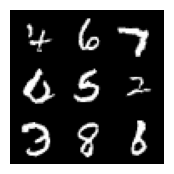

In [17]:
# Plotting the samples saved from the last epoch
img = mpimg.imread("results/steps_{:0>8}.png".format(global_steps))

plt.figure(figsize=(2, 2))
plt.imshow(img)
plt.axis('off')
plt.show()

Sampling: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:15<00:00, 63.35it/s]


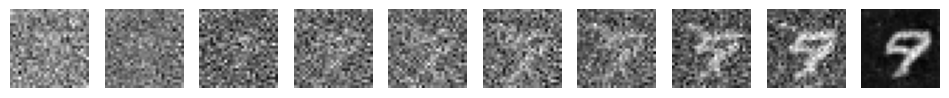

In [39]:
# Plotting the intermediate diffusion steps
imgs = model_ema.module.sample_intermediate_images()
fig, axes = plt.subplots(1, len(imgs), figsize=(12, 2))
for img, ax in zip(imgs, axes.flat):
    ax.imshow(img.squeeze(), cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.savefig('steps.png')